# Transfer Learning by Fine Tuning Seed Value 7
Repository: https://github.com/ZainK-hub/satbinclass

This notebook uses the versions listed below of the following packages:
* Python: 3.7.4
* PANDAS: 0.25.1
* Numpy: 1.17.2
* Matplotlib: 3.1.1
* Scikit-learn: 0.21.3
* Scipy: 1.3.1
* Tensorflow-GPU 1.14.0
* Tensorflow 1.14.0
* CUDA toolkit: 10.1.168
* CUDNN: 7.6.0
* Keras-GPU: 2.2.4
* Keras-preprocessing: 1.1.0

In [1]:
#Seed random generators to ensure reproducible results
from numpy.random import seed
seed(7)
from tensorflow import set_random_seed 
set_random_seed(7)
from math import ceil
import efficientnet.keras as efn
from efficientnet.keras import center_crop_and_resize #, preprocess_input

import time
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from keras.utils import np_utils, to_categorical, plot_model
from keras.applications import imagenet_utils, resnet50, resnet
from keras.applications import resnext
from keras.applications.resnet_v2 import ResNet50V2, ResNet101V2, ResNet152V2, preprocess_input
from keras.wrappers.scikit_learn import KerasClassifier
#from kerastuner.tuners import RandomSearch

from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, Nadam, SGD
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, GlobalMaxPooling2D, Average, Concatenate
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint, Callback, EarlyStopping
import matplotlib.pyplot as plt
from keras.backend import clear_session
#free GPU memory
clear_session()

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/learner/anaconda3/envs/tfgpu/lib/python3

In [2]:
import tensorflow  as tf
from tensorflow.python.client import device_lib
#device_lib.list_local_devices()


## Introduction

This notebook contains the code for image classification using Transfer Learning by Fine Tuning with the ResNet50 and EfficientNetB4 built-in models. A new *random_state* or *seed* value of 7 is used in determining the data splits.

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, \
    confusion_matrix, make_scorer
import pandas as pd

## Data preprocessing

The data is read in and preprocessed. Each model's own preprocessing is used. 

*StratifiedShuffleSplit* is used to ensure that the data is split and shuffled in such a way that the percentage of the categories of the data relative to the original dataset is maintained. A test dataset is made and separated from the dataset that will be used to train the model so as to not train on the data used to quantify the model performance since cross-validation is used.

Data Augmentation is also done to increase the generalisability of the model.

In [4]:
X = np.load('X.npy')
y = np.load('y.npy')
#One hot encoding
one_hot_y = to_categorical(y)
#y = one_hot_y
print(X.shape)

(224, 224, 6, 1440)


In [5]:
print(y.shape)
y = np.ravel(y)
y.shape

(1440, 1)


(1440,)

In [6]:
img_res = X.shape[0]
blobs = X.shape[3]
X = X.T
print(X.shape)

(1440, 6, 224, 224)


In [7]:
#Scale the disp, ph and coh bands to 0 to 255
def scaleBandData(X):
    blobs = X.shape[0]
    bands = X.shape[1]
    print('band input shape', X.shape)
    X = X.T
    print('scale band data shape', X.shape)
    X = X.reshape(X.shape[0]*X.shape[1]*X.shape[2], X.shape[3]).T
    print('scale band data reshaped', X.shape)
    scaler = MinMaxScaler(feature_range=(0,255), copy=False)
    scaler = scaler.fit(X)
    X = scaler.transform(X)
    X = X.reshape(blobs, bands, img_res, img_res)
    print('band output shape', X.shape)
    return X
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))
X[:,0:3,:,:] = scaleBandData(X[:,0:3,:,:])
print('max, min', np.max(X[:,0:3,:,:]), np.min(X[:,0:3,:,:]))

max, min 3.1391279697418213 -3.1403708457946777
band input shape (1440, 3, 224, 224)
scale band data shape (224, 224, 3, 1440)
scale band data reshaped (1440, 150528)
band output shape (1440, 3, 224, 224)
max, min 255.00000000000006 0.0


In [8]:
print(X.shape)
print('max, min', np.max(X), np.min(X))

(1440, 6, 224, 224)
max, min 255.00000000000006 0.0


In [9]:
#Reshape to Keras desired shape
X = X.reshape(X.shape[0], X.shape[2], X.shape[3], X.shape[1])
print(X.shape)

(1440, 224, 224, 6)


## Classification

The classifiers are implemented below using Transfer Learning by Fine Tuning with the ResNet50 and EfficientB4 models.

In [10]:
#Below code for multiple generator adapted from: https://github.com/keras-team/keras/issues/8130 
def multi_gen(generator, X, Y, batch_size, img_height,img_width):    
    gen_X0 = generator.flow(X[0], Y, batch_size = batch_size, shuffle=False, seed=7)    
    gen_X1 = generator.flow(X[1], batch_size = batch_size, shuffle=False, seed=7)
    
    while True:
            X0 = gen_X0.next()
            X1 = gen_X1.next()
            #Yield the 2 x 3 channel inputs and their mutual label
            #Had to rename input_2 to input_2_2 when renaming all layers in resnet_2
            yield ({'input_1': X0[0], 'input_2_2': X1[0]}, {'output': X0[1]})

#Below timing code adapted from: https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
import time
class TimeHist(Callback):
    def at_train_start(self, logs={}):
        self.times = []

    def at_epoch_start(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def at_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [11]:
#Setup single models
def singleModel(img_res, model_str, X_band_train_val, X_band_test, X_rgb_train_val, X_rgb_test, y_train, y_val, 
                y_test, train_index, val_index, single_model_name_str, results_arr, dropout, counter):
    
    #For fine tuning set to 'imagenet'
    weights_str = 'imagenet'
        
    img_h = img_res
    img_w = img_res
    batch_Size = 32
    
    print(single_model_name_str)
    X_band_train = X_band_train_val[train_index].copy()
    X_band_val = X_band_train_val[val_index].copy()
    X_band_test = X_band_test.copy()
    X_rgb_train = X_rgb_train_val[train_index].copy()
    X_rgb_val = X_rgb_train_val[val_index].copy()
    X_rgb_test = X_rgb_test.copy()
    print('Band: Train: ', X_band_train.shape, 'Validation:', X_band_val.shape, 'Test:', X_band_test.shape)         
    print('RGB: Train: ', X_rgb_train.shape, 'Validation:', X_rgb_val.shape, 'Test:', X_rgb_test.shape)         
    del X_band_train_val, X_rgb_train_val
    
    if model_str == 'ResNet50':
        print("\n ResNet model \n")
        net_1 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = resnet.ResNet50(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 171 #168 
    elif model_str == 'EffNetB4':
        print("\n EfficientNet model \n")
        net_1 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        net_2 = efn.EfficientNetB4(weights=weights_str, include_top=False, input_shape=(img_h, img_w, 3))
        last_conv_layer_no = 464 #460

    print(model_str + ' 1 input shape:', net_1.input.shape)
    print(model_str + ' 1 output shape:', net_1.output.shape)

    training_size = X_band_train.shape[0]
    validating_size = X_band_val.shape[0]
    testing_size = X_band_test.shape[0]

    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    y_test = to_categorical(y_test)

    for layer in net_2.layers:
        layer.name = layer.name + str('_2')

    preds1 = net_1.output
    preds1 = GlobalAveragePooling2D()(preds1)
    preds1 = Dropout(dropout)(preds1)
    #preds1 = Dense(512, activation='relu',)(preds1)
    #preds1 = Dropout(dropout)(preds1)
    preds1 = Dense(2, activation='softmax', name='Softmax_1')(preds1)
    preds2 = net_2.output
    preds2 = GlobalAveragePooling2D()(preds2)
    preds2 = Dropout(dropout)(preds2)
    #preds2 = Dense(512, activation='relu',)(preds2)
    #preds2 = Dropout(dropout)(preds2)
    preds2 = Dense(2, activation='softmax', name='Softmax_2')(preds2)
    preds = Average()([preds1, preds2])

    cnn_model = Model(inputs = [net_1.input, net_2.input], outputs = preds, name='ensemble')

    #Freeze the resnet layers except the final layer
    for layer in net_1.layers:
        layer.trainable = False
    for layer in net_2.layers:
        layer.trainable = False

    #optim = Adam(lr=0.0001)
    #optim = 'Adam'
    #optim = SGD(lr=1e-3, momentum=0.9, decay=1e-3/25)
    optim = SGD(lr=1e-4, momentum=0.9)
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])
    time_callback = TimeHist()
    #chkpt_path = "/from_scratch/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
    chkpt_path = './model/' + single_model_name_str + '_bestmodel.hdf5'
    checkpointer = ModelCheckpoint(filepath=chkpt_path, monitor = 'val_loss',
                                   mode='min', verbose=1, save_best_only=True)                

    input_imgen = ImageDataGenerator(shear_range = 0.30, zoom_range = 0.30, width_shift_range=0.3, 
                height_shift_range=0.3, rotation_range = 60, horizontal_flip = True, fill_mode='nearest')
    #input_imgen = ImageDataGenerator(shear_range = 0.2, zoom_range = 0.2, rotation_range = 5., 
    #                                 horizontal_flip = True)
    val_imgen = ImageDataGenerator()
    test_imgen = ImageDataGenerator()

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)  
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=0, mode='auto', 
                                 min_lr=0.000001)
    callbacks_list = [checkpointer, time_callback, reduceLR, es,]
    
    train_generator = input_imgen.flow([X_band_train.copy(), X_rgb_train.copy()], y_train.copy(), 
                    batch_size=batch_Size, shuffle=False)
    val_generator = val_imgen.flow([X_band_val.copy(), X_rgb_val.copy()], y_val.copy(), batch_size=batch_Size, shuffle=False)
    test_generator = test_imgen.flow([X_band_test.copy(), X_rgb_test.copy()], batch_size=batch_Size, shuffle=False)
    
    history = cnn_model.fit_generator(train_generator, steps_per_epoch=round(training_size/batch_Size), epochs = 50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    test_preds = cnn_model.predict_generator(test_generator, steps=round(testing_size/batch_Size))
    
    #Testing Accuracy before unfreezing the final conv block
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    
    print('\n', single_model_name_str + ' : Counter: %i, Testing Accuracy: %.2f %% \n' % (counter, test_acc))
    results_arr.append(test_acc)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    #Unfreeze the final conv block, its 171 and not 49 for ResNet50
    for layer in net_1.layers[last_conv_layer_no:]:
        layer.trainable = True
    for layer in net_2.layers[last_conv_layer_no:]:
        layer.trainable = True

    #Print trainable layers
    if counter == 0:
        count = 0
        for layer in net_1.layers:
            print(model_str + ' 1: {} {}: {}'.format(count, layer, layer.trainable))
            count = count + 1
        count = 0
        for layer in net_2.layers:
            print(model_str + ' 2: {} {}: {}'.format(count, layer, layer.trainable))
            count = count + 1

    print('\n \n ############################################### \n \n Retraining with last conv layer unfrozen \n ')
    cnn_model.compile(loss='binary_crossentropy', optimizer = optim, metrics=['accuracy'])

    history = cnn_model.fit_generator(train_generator, steps_per_epoch = round(training_size/batch_Size), epochs =50, 
        callbacks=callbacks_list, validation_data = val_generator, validation_steps = ceil(validating_size/batch_Size), shuffle=False)

    #load the saved model
    saved_model = load_model(chkpt_path)
    
    train_generator.reset()
    val_generator.reset()
    test_generator.reset()
    
    train_preds = saved_model.predict_generator(train_generator, steps = round(training_size/batch_Size))
    val_preds = saved_model.predict_generator(val_generator, steps = ceil(validating_size/batch_Size))
    
    test_preds = saved_model.predict_generator(test_generator, steps = round(testing_size/batch_Size))
    print('validating_size', validating_size, 'val_preds', val_preds.shape, 'y_val: ', y_val.shape)
    
    #train_acc = round(accuracy_score(np.argmax(y_train.copy(), axis=1), np.argmax(train_preds.copy(), axis=1))*100, 2)
    val_acc = round(accuracy_score(np.argmax(y_val.copy(), axis=1), np.argmax(val_preds.copy(), axis=1))*100, 2)
    test_acc = round(accuracy_score(np.argmax(y_test.copy(), axis=1), np.argmax(test_preds.copy(), axis=1))*100, 2)
    print(single_model_name_str + ' : Counter: %i, Accuracies: Validation: %.2f %%, Test: %.2f %%' % (counter, 
            val_acc, test_acc))

    if counter == 0:
        plot_model(cnn_model, to_file= './model/' + single_model_name_str + '_Architecture.png')
        #cnn_model.summary()

    #Visualisation code from Keras API dcumentation: https://keras.io/visualization/
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Accuracy_' + str(counter) + '.png')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.savefig('./model/' + single_model_name_str + '_Loss_' + str(counter) + '.png')
    plt.show()

    del history, saved_model, cnn_model
    
    results_arr.append(val_acc)
    results_arr.append(test_acc)     
    results_arr = evaluator(np.round(np.argmax(test_preds.copy(),axis=1)), np.argmax(y_test.copy(), axis=1), results_arr)
    
    del X_band_train, X_rgb_train, X_band_val, X_rgb_val, y_train, y_val, y_test, X_band_test, X_rgb_test
    clear_session()
    del net_1, net_2, train_preds 
    return val_preds, test_preds, results_arr


#Evaluate performance
def evaluator(test_preds, y_test, results_arr):
    f1_sco = round(f1_score(y_test, np.round(test_preds), average='macro'), 2)
    precision = round(precision_score(y_test, np.round(test_preds), average='macro'), 2)
    recall = round(recall_score(y_test, np.round(test_preds), average='macro'), 2)
    print('F1 score is: ', f1_sco)
    print('Recall score is: ', precision)
    print('Precision score is: ', recall)

    confu = confusion_matrix(y_test, test_preds)
    print('Confusion matrix: \n', confu)
    print('From the confusion matrix above there are ' + str(confu[0, 0]) + ' true negatives and ' + str(confu[0, 1]) 
          + ' false positives.') 
    print('There are ' + str(confu[1, 0]) + ' false negatives and ' + str(confu[1, 1]) + ' true positives. \n')
    performance = np.array((f1_sco, precision, recall, confu[0, 0], confu[0, 1], confu[1, 0], confu[1, 1]))
    for i in range(len(performance)):
        results_arr.append(performance[i])
    return results_arr
    
#Ensemble models
def ensembler(val_preds, test_preds, y_val, y_test, ensemble_str, results_arr):
    val_preds = np.mean(val_preds, axis=0)
    test_preds = np.mean(test_preds, axis=0)
    ensemble_preds_val = np.argmax(val_preds, axis=1)
    ensemble_preds_test = np.argmax(test_preds, axis=1)
    ensemble_val_acc = np.round(accuracy_score(y_val, np.round(ensemble_preds_val))*100, 2)
    print('Validation score of ' + ensemble_str + ': ', ensemble_val_acc, '%')
    ensemble_test_acc = np.round(accuracy_score(y_test.copy(), np.round(ensemble_preds_test))*100, 2)
    print('Test score of ' + ensemble_str + ': ', ensemble_test_acc, '%')
    
    results_arr.append('N/A')    
    results_arr.append(ensemble_val_acc)
    results_arr.append(ensemble_test_acc)
    results_arr = evaluator(np.round(ensemble_preds_test.copy()), y_test.copy(), results_arr)
    return results_arr

In [12]:
#Function to train model 
def trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test, 
               y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test):
        
    sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=7)
    sss.get_n_splits(X_resnet50_band_train_val, y_train_val)

    dropout=[0.2, 0.3, 0.4]
    single_model_name = ['ResNet50 FT Seed 7 Dropout: ' + str(dropout[0]), 'ResNet50 FT Seed 7 Dropout: ' + str(dropout[1]), 
                         'ResNet50 FT Seed 7 Dropout: ' + str(dropout[2]), 'EfficientNet B4 Seed 7 FT Dropout: ' + str(dropout[0]),
                        'EfficientNet B4 Seed 7 FT Dropout: ' + str(dropout[1]), 'EfficientNet B4 Seed 7 FT Dropout: ' + str(dropout[2]),]
    for i in range(len(single_model_name)):
        print('Model ' + str(i + 1) + ': ' + single_model_name[i])
    
    #Results column names
    col_names = ['Counter',]
    subnames = ['Test Acc B4 Unfreezing Last Conv Layer', 'Val Acc', 'Test Acc', 'F1 score', 'Precision', 'Recall', 'True Neg.', 'False Pos.', 'False Neg.', 'True Pos.',]
    for i in range(len(single_model_name)):
        for j in range(len(subnames)):
            col_names.append(single_model_name[i] + ' ' + subnames[j])
    
    ensemble_names = ['Ensemble of 1 & 2',]
    for i in range(len(ensemble_names)):
        for j in range(len(subnames)):
            col_names.append(ensemble_names[i] + ' ' + subnames[j])
    
    results_data = pd.DataFrame(columns=col_names)
    results_arr = []
    
    counter = 0
    for train_index, val_index in sss.split(X_resnet50_band_train_val, y_train_val):
        #Test to see if there any overlapped indices
        print('Overlap',set(train_index) & set (val_index))
        print('Counter: ',counter)
        
        results_arr.append(counter)
        
        y_train = y_train_val[train_index].copy()
        y_val = y_train_val[val_index].copy()
        y_test = y_test.copy()
 
        # Model 1 ResNet50 Fine Tuning
        preds_1, test_preds_1, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[0], results_arr, dropout[0], counter)
        
        preds_2, test_preds_2, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[1], results_arr, dropout[1], counter)

        preds_3, test_preds_3, results_arr = singleModel(img_res, 'ResNet50', X_resnet50_band_train_val.copy(), 
            X_resnet50_band_test.copy(), X_resnet50_rgb_train_val.copy(), X_resnet50_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[2], results_arr, dropout[2], counter)
        
        # Model 2 EfficientNet B4 Fine Tuning
        preds_4, test_preds_4, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[3], results_arr, dropout[0], counter)
                    
        preds_5, test_preds_5, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[4], results_arr, dropout[1], counter)
                    
        preds_6, test_preds_6, results_arr = singleModel(img_res, 'EffNetB4', X_effnet_band_train_val.copy(), 
            X_effnet_band_test.copy(), X_effnet_rgb_train_val.copy(), X_effnet_rgb_test.copy(), y_train.copy(), 
            y_val.copy(), y_test.copy(), train_index, val_index, single_model_name[5], results_arr, dropout[2], counter)
        
        #Ensembling
        val_preds = np.stack((preds_1, preds_2))
        test_preds = np.stack((test_preds_1, test_preds_2))
        results_arr = ensembler(val_preds, test_preds, y_val.copy(), y_test.copy(), ensemble_names[0], results_arr)
           
        #Append to data frame    
        temp_df2 = pd.DataFrame([results_arr], columns=col_names) 
        results_data = results_data.append(temp_df2, ignore_index=True, sort=False)
        print('results_data \n\n', results_data)
        results_arr.clear()
            
        counter = counter + 1
        del y_train, y_val, 
        
    print('10-fold cross validation has completed. \n Mean scores are :')
    print(results_data.mean(axis=0))
    results_copy  = results_data.copy()
    temp_df2 = pd.DataFrame(results_data.mean(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.var(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)
    temp_df2 = pd.DataFrame(results_copy.std(axis=0))
    results_data = results_data.append(temp_df2.T, ignore_index=True, sort=False)

    del X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, X_resnet50_rgb_test
    del X_effnet_band_train_val, X_effnet_band_test, X_effnet_rgb_train_val, X_effnet_rgb_test
    return results_data

X, y shapes:  (1440, 224, 224, 6) (1440,)
X_resnet50_band_train_val processed: max, min 151.061 -123.68
X_resnet50_rgb_train_val processed: max, min 151.061 -123.68
X_resnet50_band_test processed: max, min 151.061 -123.68
X_resnet50_rgb_test processed: max, min 151.061 -123.68
X_effnet_bands_train_val processed: max, min 2.64 -2.117904
X_effnet_rgb_train_val processed: max, min 2.64 -2.117904
X_effnet_bands_test processed: max, min 2.64 -2.117904
X_effnet_rgb_test processed: max, min 2.64 -2.117904
Model 1: ResNet50 FT Seed 7 Dropout: 0.2
Model 2: ResNet50 FT Seed 7 Dropout: 0.3
Model 3: ResNet50 FT Seed 7 Dropout: 0.4
Model 4: EfficientNet B4 Seed 7 FT Dropout: 0.2
Model 5: EfficientNet B4 Seed 7 FT Dropout: 0.3
Model 6: EfficientNet B4 Seed 7 FT Dropout: 0.4
Overlap set()
Counter:  0
ResNet50 FT Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 22


Epoch 00021: val_loss improved from 0.56290 to 0.55863, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 22/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4627 - acc: 0.7922 - val_loss: 0.5560 - val_acc: 0.7619

Epoch 00022: val_loss improved from 0.55863 to 0.55597, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 23/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4680 - acc: 0.7881 - val_loss: 0.5503 - val_acc: 0.7619

Epoch 00023: val_loss improved from 0.55597 to 0.55028, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 24/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4690 - acc: 0.7962 - val_loss: 0.5475 - val_acc: 0.7662

Epoch 00024: val_loss improved from 0.55028 to 0.54753, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 25/50
29/29 [==============================] - 8s 288ms/step - loss: 0.4566 - acc: 

Epoch 1/50
29/29 [==============================] - 13s 446ms/step - loss: 0.3856 - acc: 0.8272 - val_loss: 0.4935 - val_acc: 0.7922

Epoch 00001: val_loss improved from 0.49502 to 0.49350, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3785 - acc: 0.8342 - val_loss: 0.4907 - val_acc: 0.7965

Epoch 00002: val_loss improved from 0.49350 to 0.49074, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3753 - acc: 0.8328 - val_loss: 0.4898 - val_acc: 0.7965

Epoch 00003: val_loss improved from 0.49074 to 0.48979, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3696 - acc: 0.8393 - val_loss: 0.4884 - val_acc: 0.7922

Epoch 00004: val_loss improved from 0.48979 to 0.48837, saving model to ./model/ResNet

29/29 [==============================] - 9s 294ms/step - loss: 0.3340 - acc: 0.8525 - val_loss: 0.4723 - val_acc: 0.8009

Epoch 00035: val_loss did not improve from 0.47208
Epoch 36/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3366 - acc: 0.8504 - val_loss: 0.4718 - val_acc: 0.8009

Epoch 00036: val_loss improved from 0.47208 to 0.47185, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 37/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3352 - acc: 0.8546 - val_loss: 0.4716 - val_acc: 0.8009

Epoch 00037: val_loss improved from 0.47185 to 0.47156, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 38/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3454 - acc: 0.8530 - val_loss: 0.4714 - val_acc: 0.8009

Epoch 00038: val_loss improved from 0.47156 to 0.47141, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 39/50
29/29 [=========================

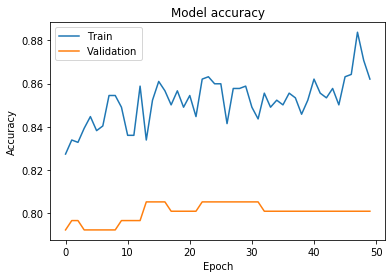

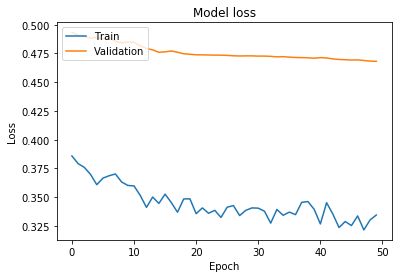

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[108  36]
 [ 39 105]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 39 false negatives and 105 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 426ms/step - loss: 0.7454 - acc: 0.5541 - val_loss: 0.7276 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.72756, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6724 - acc: 0.6035 - val_loss: 0.7082 - val_acc: 0.5541

Epoch 00002: val_loss improved from 0.72756 to 0.70

Epoch 1/50
29/29 [==============================] - 13s 435ms/step - loss: 0.4514 - acc: 0.8053 - val_loss: 0.5940 - val_acc: 0.6710

Epoch 00001: val_loss improved from 0.60071 to 0.59402, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 292ms/step - loss: 0.4598 - acc: 0.7913 - val_loss: 0.5940 - val_acc: 0.6710

Epoch 00002: val_loss did not improve from 0.59402
Epoch 3/50
29/29 [==============================] - 8s 293ms/step - loss: 0.4567 - acc: 0.7999 - val_loss: 0.5939 - val_acc: 0.6710

Epoch 00003: val_loss improved from 0.59402 to 0.59387, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 8s 293ms/step - loss: 0.4659 - acc: 0.8056 - val_loss: 0.5934 - val_acc: 0.6710

Epoch 00004: val_loss improved from 0.59387 to 0.59343, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 5/50
29/29 [=================

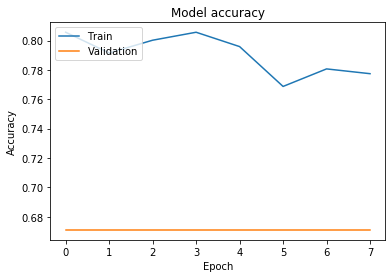

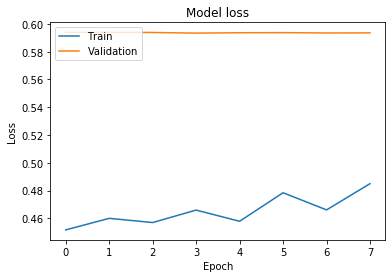

F1 score is:  0.67
Recall score is:  0.69
Precision score is:  0.68
Confusion matrix: 
 [[117  27]
 [ 65  79]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 65 false negatives and 79 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 409ms/step - loss: 0.7821 - acc: 0.5204 - val_loss: 0.7652 - val_acc: 0.5281

Epoch 00001: val_loss improved from inf to 0.76516, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 284ms/step - loss: 0.7255 - acc: 0.5762 - val_loss: 0.7397 - val_acc: 0.5368

Epoch 00002: val_loss improved from 0.76516 to 0.739

Epoch 1/50
29/29 [==============================] - 15s 519ms/step - loss: 0.5099 - acc: 0.7517 - val_loss: 0.6364 - val_acc: 0.6061

Epoch 00001: val_loss did not improve from 0.63577
Epoch 2/50
29/29 [==============================] - 9s 295ms/step - loss: 0.5109 - acc: 0.7501 - val_loss: 0.6365 - val_acc: 0.6017

Epoch 00002: val_loss did not improve from 0.63577
Epoch 3/50
29/29 [==============================] - 9s 293ms/step - loss: 0.4967 - acc: 0.7706 - val_loss: 0.6371 - val_acc: 0.6061

Epoch 00003: val_loss did not improve from 0.63577
Epoch 4/50
29/29 [==============================] - 9s 294ms/step - loss: 0.4972 - acc: 0.7581 - val_loss: 0.6371 - val_acc: 0.6061

Epoch 00004: val_loss did not improve from 0.63577
Epoch 5/50
29/29 [==============================] - 9s 294ms/step - loss: 0.5188 - acc: 0.7450 - val_loss: 0.6366 - val_acc: 0.6017

Epoch 00005: val_loss did not improve from 0.63577
Epoch 00005: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231

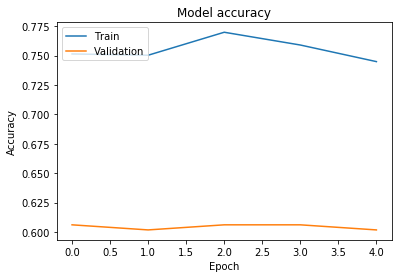

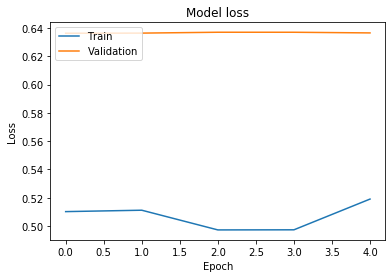

F1 score is:  0.55
Recall score is:  0.7
Precision score is:  0.6
Confusion matrix: 
 [[137   7]
 [107  37]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 107 false negatives and 37 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 916ms/step - loss: 0.7117 - acc: 0.5093 - val_loss: 0.6919 - val_acc: 0.5152

Epoch 00001: val_loss improved from inf to 0.69187, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.7118 - acc: 0.4999 - val_loss: 0.6890 - val_acc: 0.5195

Epoch 00002: val_loss improved fr


Epoch 00029: val_loss improved from 0.62833 to 0.62676, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6469 - acc: 0.6443 - val_loss: 0.6247 - val_acc: 0.6667

Epoch 00030: val_loss improved from 0.62676 to 0.62470, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 543ms/step - loss: 0.6346 - acc: 0.6811 - val_loss: 0.6230 - val_acc: 0.6710

Epoch 00031: val_loss improved from 0.62470 to 0.62302, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6453 - acc: 0.6315 - val_loss: 0.6214 - val_acc: 0.6840

Epoch 00032: val_loss improved from 0.62302 to 0.62137, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 1/50
29/29 [==============================] - 27s 919ms/step - loss: 0.5943 - acc: 0.7159 - val_loss: 0.5857 - val_acc: 0.7489

Epoch 00001: val_loss improved from 0.59544 to 0.58565, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5989 - acc: 0.7082 - val_loss: 0.5837 - val_acc: 0.7446

Epoch 00002: val_loss improved from 0.58565 to 0.58371, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5987 - acc: 0.7166 - val_loss: 0.5821 - val_acc: 0.7446

Epoch 00003: val_loss improved from 0.58371 to 0.58213, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5892 - acc: 0.7334 - val_loss: 0.5809 - val_acc: 0.7489

Epoch 00004: val_loss improved from 0.58213 to 0.58093, saving


Epoch 00031: val_loss improved from 0.55364 to 0.55285, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5424 - acc: 0.7622 - val_loss: 0.5521 - val_acc: 0.7879

Epoch 00032: val_loss improved from 0.55285 to 0.55210, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5401 - acc: 0.7633 - val_loss: 0.5512 - val_acc: 0.7835

Epoch 00033: val_loss improved from 0.55210 to 0.55123, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5411 - acc: 0.7652 - val_loss: 0.5505 - val_acc: 0.7835

Epoch 00034: val_loss improved from 0.55123 to 0.55050, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 16s 5

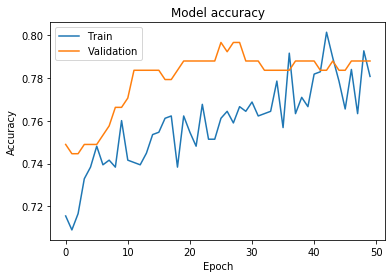

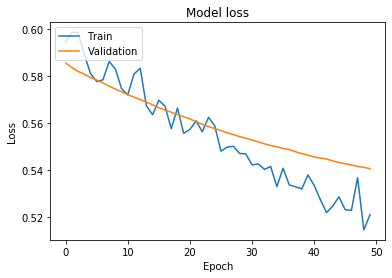

F1 score is:  0.76
Recall score is:  0.76
Precision score is:  0.76
Confusion matrix: 
 [[114  30]
 [ 40 104]]
From the confusion matrix above there are 114 true negatives and 30 false positives.
There are 40 false negatives and 104 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 862ms/step - loss: 0.6948 - acc: 0.5378 - val_loss: 0.6875 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.68748, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.6945 - acc: 0.5389 - val_loss: 0.6856 - val_acc: 0.5498

Epoch 00002: val_loss improved


Epoch 00029: val_loss improved from 0.64995 to 0.64895, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6219 - acc: 0.6926 - val_loss: 0.6480 - val_acc: 0.6364

Epoch 00030: val_loss improved from 0.64895 to 0.64797, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6107 - acc: 0.7056 - val_loss: 0.6469 - val_acc: 0.6407

Epoch 00031: val_loss improved from 0.64797 to 0.64694, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6197 - acc: 0.6865 - val_loss: 0.6458 - val_acc: 0.6450

Epoch 00032: val_loss improved from 0.64694 to 0.64584, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 1/50
29/29 [==============================] - 26s 881ms/step - loss: 0.5834 - acc: 0.7460 - val_loss: 0.6266 - val_acc: 0.6537

Epoch 00001: val_loss improved from 0.63127 to 0.62664, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5819 - acc: 0.7312 - val_loss: 0.6258 - val_acc: 0.6537

Epoch 00002: val_loss improved from 0.62664 to 0.62583, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5721 - acc: 0.7617 - val_loss: 0.6254 - val_acc: 0.6537

Epoch 00003: val_loss improved from 0.62583 to 0.62537, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5823 - acc: 0.7250 - val_loss: 0.6242 - val_acc: 0.6580

Epoch 00004: val_loss improved from 0.62537 to 0.62415, saving

Epoch 32/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5433 - acc: 0.7592 - val_loss: 0.6076 - val_acc: 0.6667

Epoch 00032: val_loss improved from 0.60820 to 0.60763, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5377 - acc: 0.7767 - val_loss: 0.6074 - val_acc: 0.6667

Epoch 00033: val_loss improved from 0.60763 to 0.60737, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5420 - acc: 0.7706 - val_loss: 0.6071 - val_acc: 0.6667

Epoch 00034: val_loss improved from 0.60737 to 0.60713, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5385 - acc: 0.7794 - val_loss: 0.6065 - val_acc: 0.6667

Epoch 00035: val_loss improved from 0.60713 to 0.60653, sa

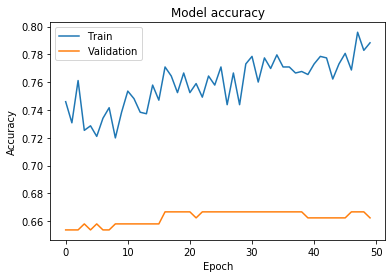

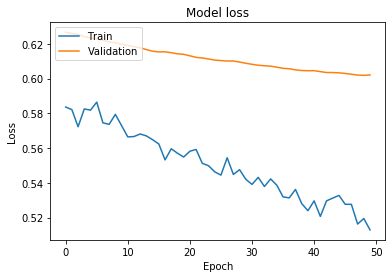

F1 score is:  0.68
Recall score is:  0.73
Precision score is:  0.69
Confusion matrix: 
 [[129  15]
 [ 73  71]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 73 false negatives and 71 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 935ms/step - loss: 0.7304 - acc: 0.4654 - val_loss: 0.7047 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.70465, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.7172 - acc: 0.4894 - val_loss: 0.7023 - val_acc: 0.4848

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.65705 to 0.65576, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 543ms/step - loss: 0.6440 - acc: 0.6287 - val_loss: 0.6545 - val_acc: 0.6061

Epoch 00030: val_loss improved from 0.65576 to 0.65453, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6400 - acc: 0.6513 - val_loss: 0.6533 - val_acc: 0.6017

Epoch 00031: val_loss improved from 0.65453 to 0.65332, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6439 - acc: 0.6515 - val_loss: 0.6520 - val_acc: 0.6104

Epoch 00032: val_loss improved from 0.65332 to 0.65200, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 1/50
29/29 [==============================] - 26s 886ms/step - loss: 0.6081 - acc: 0.6875 - val_loss: 0.6318 - val_acc: 0.6320

Epoch 00001: val_loss improved from 0.63458 to 0.63179, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 556ms/step - loss: 0.6066 - acc: 0.6923 - val_loss: 0.6306 - val_acc: 0.6320

Epoch 00002: val_loss improved from 0.63179 to 0.63063, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5959 - acc: 0.6948 - val_loss: 0.6296 - val_acc: 0.6364

Epoch 00003: val_loss improved from 0.63063 to 0.62957, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 16s 550ms/step - loss: 0.6033 - acc: 0.6883 - val_loss: 0.6287 - val_acc: 0.6407

Epoch 00004: val_loss improved from 0.62957 to 0.62873, saving


Epoch 00031: val_loss improved from 0.60842 to 0.60805, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5498 - acc: 0.7557 - val_loss: 0.6076 - val_acc: 0.6450

Epoch 00032: val_loss improved from 0.60805 to 0.60762, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5440 - acc: 0.7684 - val_loss: 0.6070 - val_acc: 0.6494

Epoch 00033: val_loss improved from 0.60762 to 0.60702, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5542 - acc: 0.7587 - val_loss: 0.6069 - val_acc: 0.6494

Epoch 00034: val_loss improved from 0.60702 to 0.60692, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 16s 5

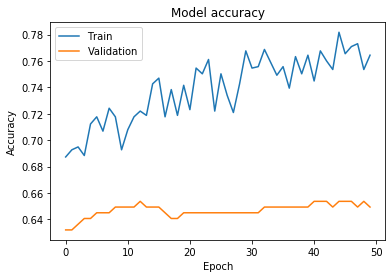

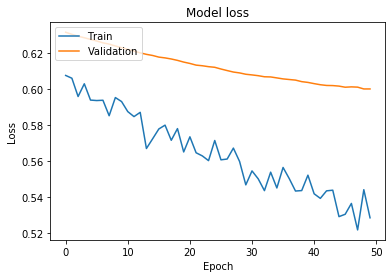

F1 score is:  0.71
Recall score is:  0.73
Precision score is:  0.71
Confusion matrix: 
 [[122  22]
 [ 61  83]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 61 false negatives and 83 true positives. 

Validation score of Ensemble of 1 & 2:  74.03 %
Test score of Ensemble of 1 & 2:  73.96 %
F1 score is:  0.74
Recall score is:  0.75
Precision score is:  0.74
Confusion matrix: 
 [[119  25]
 [ 50  94]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 50 false negatives and 94 true positives. 

results_data 

   Counter  \
0       0   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        

   ResNet50 FT Seed 7 Dropout: 0.2 Val Acc  \
0                                    80.09   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc  \
0                                     73.96   

   ResNet50 FT Seed 7 Dr


Epoch 00022: val_loss improved from 0.57972 to 0.57687, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 23/50
29/29 [==============================] - 8s 285ms/step - loss: 0.4710 - acc: 0.7789 - val_loss: 0.5748 - val_acc: 0.7532

Epoch 00023: val_loss improved from 0.57687 to 0.57477, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 24/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4610 - acc: 0.7869 - val_loss: 0.5712 - val_acc: 0.7576

Epoch 00024: val_loss improved from 0.57477 to 0.57124, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 25/50
29/29 [==============================] - 8s 285ms/step - loss: 0.4551 - acc: 0.7918 - val_loss: 0.5681 - val_acc: 0.7576

Epoch 00025: val_loss improved from 0.57124 to 0.56808, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 26/50
29/29 [==============================] - 9s 300ms/step - loss: 0.4572 - acc: 


Epoch 00004: val_loss did not improve from 0.52800
Epoch 5/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3749 - acc: 0.8344 - val_loss: 0.5285 - val_acc: 0.7792

Epoch 00005: val_loss did not improve from 0.52800
Epoch 6/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3797 - acc: 0.8295 - val_loss: 0.5268 - val_acc: 0.7792

Epoch 00006: val_loss improved from 0.52800 to 0.52684, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 7/50
29/29 [==============================] - 9s 323ms/step - loss: 0.3642 - acc: 0.8326 - val_loss: 0.5242 - val_acc: 0.7835

Epoch 00007: val_loss improved from 0.52684 to 0.52415, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 8/50
29/29 [==============================] - 9s 316ms/step - loss: 0.3724 - acc: 0.8420 - val_loss: 0.5247 - val_acc: 0.7792

Epoch 00008: val_loss did not improve from 0.52415
Epoch 9/50
29/29 [==============================] - 9s 293ms

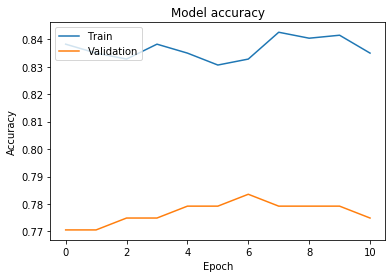

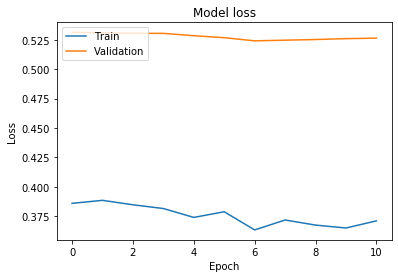

F1 score is:  0.71
Recall score is:  0.72
Precision score is:  0.72
Confusion matrix: 
 [[ 94  50]
 [ 32 112]]
From the confusion matrix above there are 94 true negatives and 50 false positives.
There are 32 false negatives and 112 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 420ms/step - loss: 0.8319 - acc: 0.5161 - val_loss: 0.7214 - val_acc: 0.5411

Epoch 00001: val_loss improved from inf to 0.72144, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 287ms/step - loss: 0.7299 - acc: 0.5358 - val_loss: 0.7365 - val_acc: 0.5498

Epoch 00002: val_loss did not improve from 0.72144
E


Epoch 00031: val_loss improved from 0.55015 to 0.54775, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4338 - acc: 0.8090 - val_loss: 0.5456 - val_acc: 0.7446

Epoch 00032: val_loss improved from 0.54775 to 0.54561, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4490 - acc: 0.8055 - val_loss: 0.5417 - val_acc: 0.7489

Epoch 00033: val_loss improved from 0.54561 to 0.54172, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4451 - acc: 0.8015 - val_loss: 0.5397 - val_acc: 0.7489

Epoch 00034: val_loss improved from 0.54172 to 0.53966, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4339 - acc: 

29/29 [==============================] - 8s 292ms/step - loss: 0.3282 - acc: 0.8529 - val_loss: 0.4832 - val_acc: 0.7835

Epoch 00046: val_loss improved from 0.48369 to 0.48322, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 47/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3183 - acc: 0.8611 - val_loss: 0.4823 - val_acc: 0.7835

Epoch 00047: val_loss improved from 0.48322 to 0.48228, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 48/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3162 - acc: 0.8632 - val_loss: 0.4814 - val_acc: 0.7835

Epoch 00048: val_loss improved from 0.48228 to 0.48144, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 49/50
29/29 [==============================] - 8s 291ms/step - loss: 0.3096 - acc: 0.8762 - val_loss: 0.4814 - val_acc: 0.7749

Epoch 00049: val_loss improved from 0.48144 to 0.48136, saving model to ./model/ResNet50 FT See

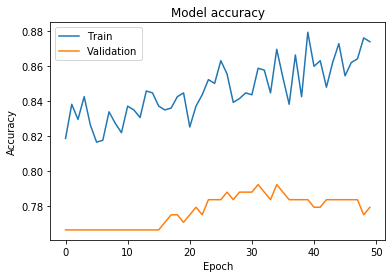

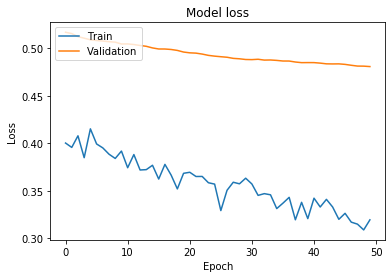

F1 score is:  0.77
Recall score is:  0.77
Precision score is:  0.77
Confusion matrix: 
 [[115  29]
 [ 38 106]]
From the confusion matrix above there are 115 true negatives and 29 false positives.
There are 38 false negatives and 106 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 416ms/step - loss: 0.8143 - acc: 0.4865 - val_loss: 0.7420 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.74197, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 286ms/step - loss: 0.7725 - acc: 0.4862 - val_loss: 0.7278 - val_acc: 0.5368

Epoch 00002: val_loss improved from 0.74197 to 0.72

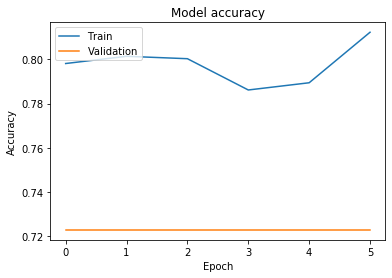

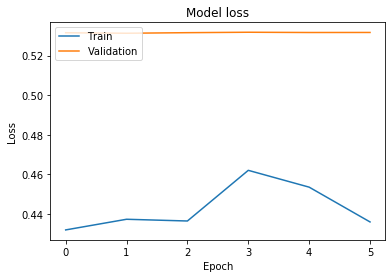

F1 score is:  0.72
Recall score is:  0.73
Precision score is:  0.72
Confusion matrix: 
 [[120  24]
 [ 56  88]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 56 false negatives and 88 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 862ms/step - loss: 0.6968 - acc: 0.5125 - val_loss: 0.7188 - val_acc: 0.4242

Epoch 00001: val_loss improved from inf to 0.71883, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 547ms/step - loss: 0.7077 - acc: 0.4942 - val_loss: 0.7167 - val_acc: 0.4286

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.67586 to 0.67460, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6309 - acc: 0.6680 - val_loss: 0.6733 - val_acc: 0.6190

Epoch 00030: val_loss improved from 0.67460 to 0.67331, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6354 - acc: 0.6502 - val_loss: 0.6721 - val_acc: 0.6234

Epoch 00031: val_loss improved from 0.67331 to 0.67208, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6330 - acc: 0.6621 - val_loss: 0.6710 - val_acc: 0.6234

Epoch 00032: val_loss improved from 0.67208 to 0.67095, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5471 - acc: 0.7524 - val_loss: 0.6179 - val_acc: 0.6623

Epoch 00040: val_loss improved from 0.61829 to 0.61795, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5307 - acc: 0.7743 - val_loss: 0.6173 - val_acc: 0.6623

Epoch 00041: val_loss improved from 0.61795 to 0.61726, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5398 - acc: 0.7794 - val_loss: 0.6171 - val_acc: 0.6580

Epoch 00042: val_loss improved from 0.61726 to 0.61712, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5398 - acc: 0.7778 - val_loss: 0.6166 - val_acc: 0.6580

Epoch 00043: val_loss improved from 0.61712 to 0.61659, sa

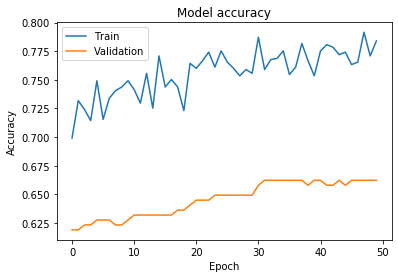

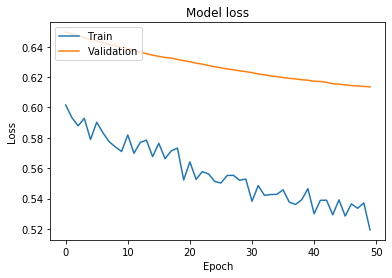

F1 score is:  0.68
Recall score is:  0.73
Precision score is:  0.69
Confusion matrix: 
 [[128  16]
 [ 72  72]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 72 false negatives and 72 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 862ms/step - loss: 0.7392 - acc: 0.4295 - val_loss: 0.7221 - val_acc: 0.4156

Epoch 00001: val_loss improved from inf to 0.72213, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7301 - acc: 0.4679 - val_loss: 0.7199 - val_acc: 0.4372

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.67817 to 0.67704, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6643 - acc: 0.6074 - val_loss: 0.6758 - val_acc: 0.5714

Epoch 00030: val_loss improved from 0.67704 to 0.67582, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6454 - acc: 0.6435 - val_loss: 0.6746 - val_acc: 0.5714

Epoch 00031: val_loss improved from 0.67582 to 0.67464, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6533 - acc: 0.6114 - val_loss: 0.6737 - val_acc: 0.5714

Epoch 00032: val_loss improved from 0.67464 to 0.67366, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5408 - acc: 0.7673 - val_loss: 0.6283 - val_acc: 0.6277

Epoch 00040: val_loss improved from 0.62881 to 0.62831, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5417 - acc: 0.7743 - val_loss: 0.6275 - val_acc: 0.6277

Epoch 00041: val_loss improved from 0.62831 to 0.62749, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5533 - acc: 0.7510 - val_loss: 0.6276 - val_acc: 0.6277

Epoch 00042: val_loss did not improve from 0.62749
Epoch 43/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5595 - acc: 0.7400 - val_loss: 0.6270 - val_acc: 0.6277

Epoch 00043: val_loss improved from 0.62749 to 0.62701, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 4

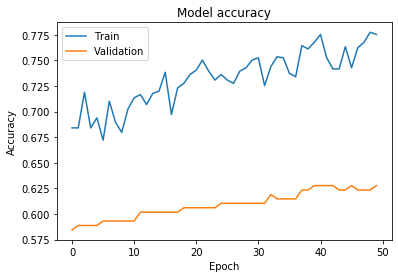

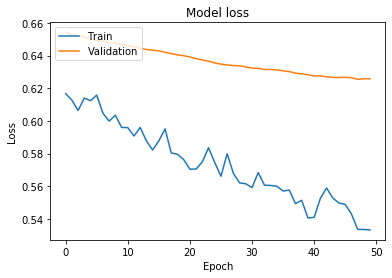

F1 score is:  0.66
Recall score is:  0.75
Precision score is:  0.68
Confusion matrix: 
 [[135   9]
 [ 82  62]]
From the confusion matrix above there are 135 true negatives and 9 false positives.
There are 82 false negatives and 62 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 856ms/step - loss: 0.6989 - acc: 0.5355 - val_loss: 0.7398 - val_acc: 0.4372

Epoch 00001: val_loss improved from inf to 0.73982, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 543ms/step - loss: 0.7011 - acc: 0.4984 - val_loss: 0.7374 - val_acc: 0.4372

Epoch 00002: val_loss improved f


Epoch 00029: val_loss improved from 0.68815 to 0.68654, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6337 - acc: 0.6465 - val_loss: 0.6850 - val_acc: 0.5498

Epoch 00030: val_loss improved from 0.68654 to 0.68498, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6335 - acc: 0.6548 - val_loss: 0.6835 - val_acc: 0.5541

Epoch 00031: val_loss improved from 0.68498 to 0.68352, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6249 - acc: 0.6696 - val_loss: 0.6822 - val_acc: 0.5628

Epoch 00032: val_loss improved from 0.68352 to 0.68218, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5538 - acc: 0.7507 - val_loss: 0.6146 - val_acc: 0.6537

Epoch 00040: val_loss improved from 0.61527 to 0.61464, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5326 - acc: 0.7778 - val_loss: 0.6140 - val_acc: 0.6537

Epoch 00041: val_loss improved from 0.61464 to 0.61398, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5400 - acc: 0.7679 - val_loss: 0.6132 - val_acc: 0.6537

Epoch 00042: val_loss improved from 0.61398 to 0.61323, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5387 - acc: 0.7618 - val_loss: 0.6125 - val_acc: 0.6537

Epoch 00043: val_loss improved from 0.61323 to 0.61253, sa

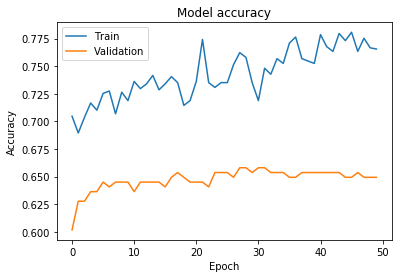

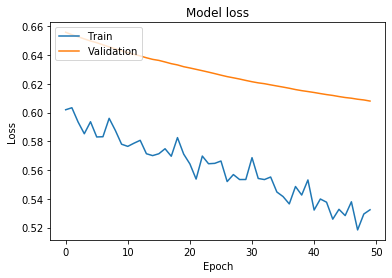

F1 score is:  0.74
Recall score is:  0.76
Precision score is:  0.74
Confusion matrix: 
 [[126  18]
 [ 56  88]]
From the confusion matrix above there are 126 true negatives and 18 false positives.
There are 56 false negatives and 88 true positives. 

Validation score of Ensemble of 1 & 2:  81.82 %
Test score of Ensemble of 1 & 2:  73.26 %
F1 score is:  0.73
Recall score is:  0.73
Precision score is:  0.73
Confusion matrix: 
 [[100  44]
 [ 33 111]]
From the confusion matrix above there are 100 true negatives and 44 false positives.
There are 33 false negatives and 111 true positives. 

results_data 

   Counter  \
0       0   
1       1   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        

   ResNet50 FT Seed 7 Dropout: 0.2 Val Acc  \
0                                    80.09   
1                            

Epoch 21/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4709 - acc: 0.7846 - val_loss: 0.6227 - val_acc: 0.6537

Epoch 00021: val_loss improved from 0.63493 to 0.62275, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 22/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4688 - acc: 0.7803 - val_loss: 0.6239 - val_acc: 0.6537

Epoch 00022: val_loss did not improve from 0.62275
Epoch 23/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4590 - acc: 0.7859 - val_loss: 0.6304 - val_acc: 0.6407

Epoch 00023: val_loss did not improve from 0.62275
Epoch 24/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4581 - acc: 0.7884 - val_loss: 0.6254 - val_acc: 0.6494

Epoch 00024: val_loss did not improve from 0.62275
Epoch 25/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4357 - acc: 0.8043 - val_loss: 0.6219 - val_acc: 0.6580

Epoch 00025: val_loss improved from 0.62275 to 0.6

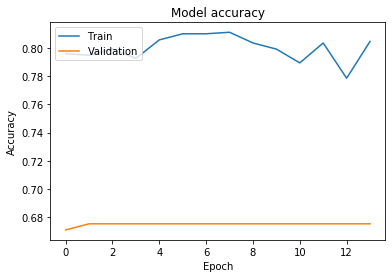

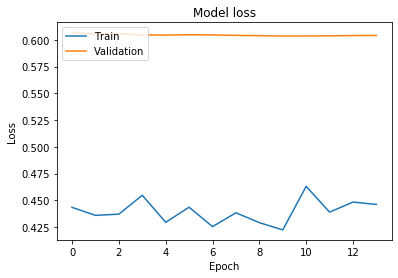

F1 score is:  0.64
Recall score is:  0.72
Precision score is:  0.66
Confusion matrix: 
 [[131  13]
 [ 84  60]]
From the confusion matrix above there are 131 true negatives and 13 false positives.
There are 84 false negatives and 60 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 413ms/step - loss: 0.7519 - acc: 0.5670 - val_loss: 0.6226 - val_acc: 0.6753

Epoch 00001: val_loss improved from inf to 0.62258, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 285ms/step - loss: 0.7289 - acc: 0.5404 - val_loss: 0.6120 - val_acc: 0.6753

Epoch 00002: val_loss improved from 0.62258 to 0.612

29/29 [==============================] - 8s 292ms/step - loss: 0.4738 - acc: 0.7811 - val_loss: 0.5226 - val_acc: 0.7143

Epoch 00007: val_loss did not improve from 0.52118
Epoch 00007: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 FT Seed 7 Dropout: 0.3 : Counter: 2, Accuracies: Validation: 71.43 %, Test: 72.92 %


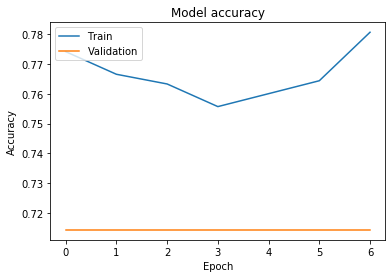

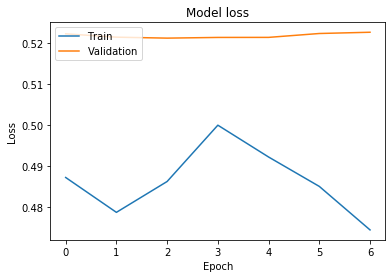

F1 score is:  0.72
Recall score is:  0.76
Precision score is:  0.73
Confusion matrix: 
 [[128  16]
 [ 62  82]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 62 false negatives and 82 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 415ms/step - loss: 0.7363 - acc: 0.5598 - val_loss: 0.7208 - val_acc: 0.5628

Epoch 00001: val_loss improved from inf to 0.72075, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 286ms/step - loss: 0.6551 - acc: 0.6353 - val_loss: 0.6979 - val_acc: 0.5584

Epoch 00002: val_loss improved from 0.72075 to 0.697

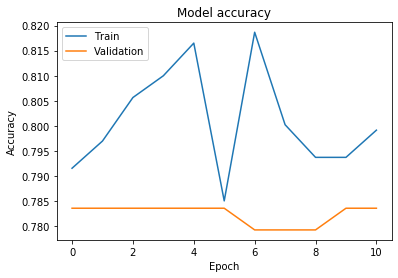

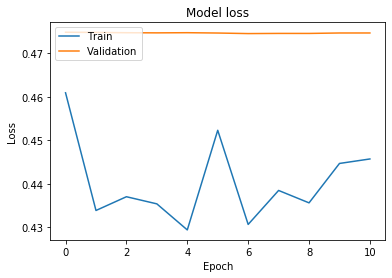

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[111  33]
 [ 43 101]]
From the confusion matrix above there are 111 true negatives and 33 false positives.
There are 43 false negatives and 101 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 924ms/step - loss: 0.7156 - acc: 0.4988 - val_loss: 0.7128 - val_acc: 0.4545

Epoch 00001: val_loss improved from inf to 0.71284, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 555ms/step - loss: 0.7121 - acc: 0.4972 - val_loss: 0.7111 - val_acc: 0.4502

Epoch 00002: val_loss improved


Epoch 00029: val_loss improved from 0.67834 to 0.67728, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6438 - acc: 0.6312 - val_loss: 0.6763 - val_acc: 0.5108

Epoch 00030: val_loss improved from 0.67728 to 0.67635, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6353 - acc: 0.6450 - val_loss: 0.6754 - val_acc: 0.5152

Epoch 00031: val_loss improved from 0.67635 to 0.67544, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6412 - acc: 0.6431 - val_loss: 0.6746 - val_acc: 0.5152

Epoch 00032: val_loss improved from 0.67544 to 0.67456, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 10/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5908 - acc: 0.7088 - val_loss: 0.6586 - val_acc: 0.5584

Epoch 00010: val_loss improved from 0.65929 to 0.65858, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 11/50
29/29 [==============================] - 16s 545ms/step - loss: 0.5873 - acc: 0.7283 - val_loss: 0.6577 - val_acc: 0.5584

Epoch 00011: val_loss improved from 0.65858 to 0.65769, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 16s 547ms/step - loss: 0.5792 - acc: 0.7272 - val_loss: 0.6572 - val_acc: 0.5584

Epoch 00012: val_loss improved from 0.65769 to 0.65724, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 545ms/step - loss: 0.5829 - acc: 0.7312 - val_loss: 0.6562 - val_acc: 0.5628

Epoch 00013: val_loss improved from 0.65724 to 0.65621, sa

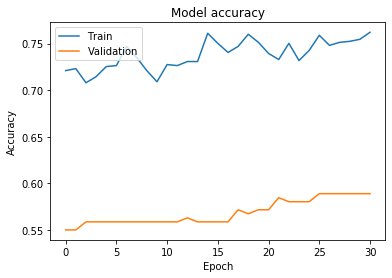

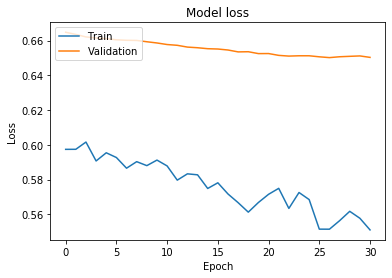

F1 score is:  0.58
Recall score is:  0.78
Precision score is:  0.63
Confusion matrix: 
 [[143   1]
 [105  39]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 105 false negatives and 39 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 877ms/step - loss: 0.6872 - acc: 0.5624 - val_loss: 0.7420 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.74203, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 552ms/step - loss: 0.6891 - acc: 0.5662 - val_loss: 0.7408 - val_acc: 0.5022

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.71529 to 0.71442, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6256 - acc: 0.6685 - val_loss: 0.7138 - val_acc: 0.5195

Epoch 00030: val_loss improved from 0.71442 to 0.71383, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6162 - acc: 0.6983 - val_loss: 0.7132 - val_acc: 0.5195

Epoch 00031: val_loss improved from 0.71383 to 0.71322, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6181 - acc: 0.6798 - val_loss: 0.7125 - val_acc: 0.5195

Epoch 00032: val_loss improved from 0.71322 to 0.71252, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

29/29 [==============================] - 16s 549ms/step - loss: 0.5319 - acc: 0.7768 - val_loss: 0.6839 - val_acc: 0.5671

Epoch 00041: val_loss did not improve from 0.68329
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5264 - acc: 0.7552 - val_loss: 0.6837 - val_acc: 0.5671

Epoch 00042: val_loss did not improve from 0.68329
Epoch 43/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5264 - acc: 0.7749 - val_loss: 0.6836 - val_acc: 0.5671

Epoch 00043: val_loss did not improve from 0.68329
Epoch 44/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5300 - acc: 0.7765 - val_loss: 0.6838 - val_acc: 0.5671

Epoch 00044: val_loss did not improve from 0.68329
Epoch 00044: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
EfficientNet B4 Seed 7 FT Dropout: 0.3 : Counter: 2, Accuracies: Validation: 56.71 %, Test: 57.29 %


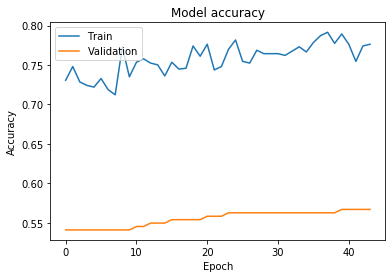

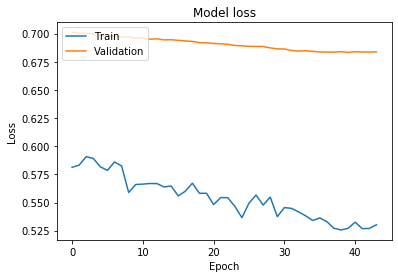

F1 score is:  0.48
Recall score is:  0.73
Precision score is:  0.57
Confusion matrix: 
 [[142   2]
 [121  23]]
From the confusion matrix above there are 142 true negatives and 2 false positives.
There are 121 false negatives and 23 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 868ms/step - loss: 0.6968 - acc: 0.5360 - val_loss: 0.6910 - val_acc: 0.5195

Epoch 00001: val_loss improved from inf to 0.69103, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 540ms/step - loss: 0.7016 - acc: 0.5282 - val_loss: 0.6893 - val_acc: 0.5325

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.65200 to 0.65091, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 542ms/step - loss: 0.6305 - acc: 0.6644 - val_loss: 0.6499 - val_acc: 0.6147

Epoch 00030: val_loss improved from 0.65091 to 0.64992, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 541ms/step - loss: 0.6258 - acc: 0.6603 - val_loss: 0.6489 - val_acc: 0.6190

Epoch 00031: val_loss improved from 0.64992 to 0.64888, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 539ms/step - loss: 0.6299 - acc: 0.6703 - val_loss: 0.6479 - val_acc: 0.6234

Epoch 00032: val_loss improved from 0.64888 to 0.64785, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5377 - acc: 0.7560 - val_loss: 0.6053 - val_acc: 0.6710

Epoch 00040: val_loss improved from 0.60566 to 0.60532, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5397 - acc: 0.7491 - val_loss: 0.6051 - val_acc: 0.6667

Epoch 00041: val_loss improved from 0.60532 to 0.60514, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5394 - acc: 0.7695 - val_loss: 0.6048 - val_acc: 0.6667

Epoch 00042: val_loss improved from 0.60514 to 0.60477, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5327 - acc: 0.7741 - val_loss: 0.6043 - val_acc: 0.6667

Epoch 00043: val_loss improved from 0.60477 to 0.60430, sa

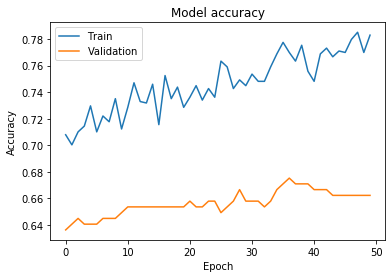

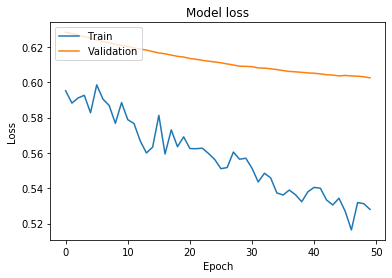

F1 score is:  0.72
Recall score is:  0.74
Precision score is:  0.72
Confusion matrix: 
 [[125  19]
 [ 61  83]]
From the confusion matrix above there are 125 true negatives and 19 false positives.
There are 61 false negatives and 83 true positives. 

Validation score of Ensemble of 1 & 2:  68.83 %
Test score of Ensemble of 1 & 2:  71.18 %
F1 score is:  0.7
Recall score is:  0.75
Precision score is:  0.71
Confusion matrix: 
 [[132  12]
 [ 71  73]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 71 false negatives and 73 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                              65.97                        

   ResNet50 FT Seed 7 Dropout: 0.


Epoch 00047: val_loss improved from 0.49080 to 0.48978, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 48/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3730 - acc: 0.8447 - val_loss: 0.4885 - val_acc: 0.7489

Epoch 00048: val_loss improved from 0.48978 to 0.48850, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 49/50
29/29 [==============================] - 8s 287ms/step - loss: 0.3757 - acc: 0.8328 - val_loss: 0.4879 - val_acc: 0.7619

Epoch 00049: val_loss improved from 0.48850 to 0.48792, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 50/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3755 - acc: 0.8369 - val_loss: 0.4872 - val_acc: 0.7619

Epoch 00050: val_loss improved from 0.48792 to 0.48719, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5

 ResNet50 FT Seed 7 Dropout: 0.2 : Counter: 3, Testing Accuracy: 71.18 % 


 
 #########

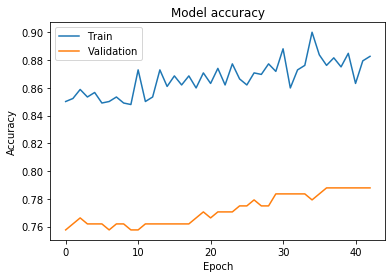

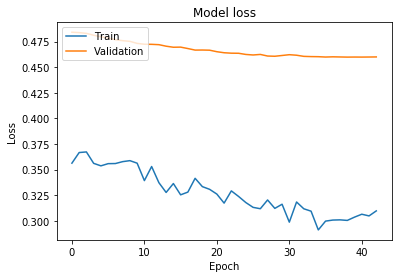

F1 score is:  0.72
Recall score is:  0.72
Precision score is:  0.72
Confusion matrix: 
 [[ 98  46]
 [ 34 110]]
From the confusion matrix above there are 98 true negatives and 46 false positives.
There are 34 false negatives and 110 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 434ms/step - loss: 0.8447 - acc: 0.4567 - val_loss: 0.9693 - val_acc: 0.5108

Epoch 00001: val_loss improved from inf to 0.96935, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 285ms/step - loss: 0.8012 - acc: 0.4673 - val_loss: 0.8846 - val_acc: 0.5195

Epoch 00002: val_loss improved from 0.96935 to 0.884

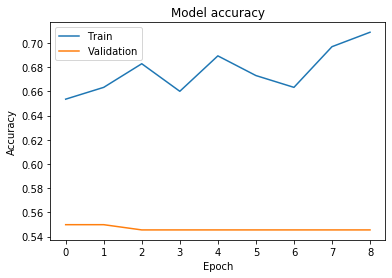

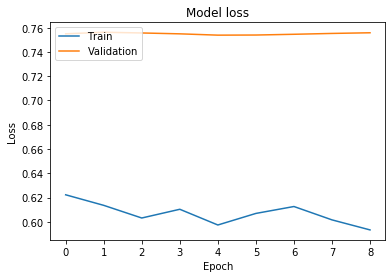

F1 score is:  0.49
Recall score is:  0.66
Precision score is:  0.57
Confusion matrix: 
 [[137   7]
 [118  26]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 118 false negatives and 26 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 14s 467ms/step - loss: 0.8047 - acc: 0.4826 - val_loss: 0.7004 - val_acc: 0.5368

Epoch 00001: val_loss improved from inf to 0.70040, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 10s 340ms/step - loss: 0.7573 - acc: 0.5353 - val_loss: 0.6800 - val_acc: 0.5541

Epoch 00002: val_loss improved from 0.70040 to 0.67

29/29 [==============================] - 8s 286ms/step - loss: 0.4697 - acc: 0.7838 - val_loss: 0.5352 - val_acc: 0.7013

Epoch 00031: val_loss improved from 0.54016 to 0.53521, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4606 - acc: 0.7879 - val_loss: 0.5346 - val_acc: 0.7013

Epoch 00032: val_loss improved from 0.53521 to 0.53459, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4642 - acc: 0.7849 - val_loss: 0.5339 - val_acc: 0.7013

Epoch 00033: val_loss improved from 0.53459 to 0.53385, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 289ms/step - loss: 0.4363 - acc: 0.8059 - val_loss: 0.5305 - val_acc: 0.7013

Epoch 00034: val_loss improved from 0.53385 to 0.53054, saving model to ./model/ResNet50 FT See

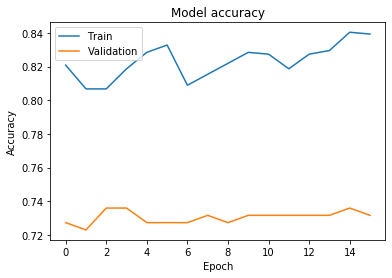

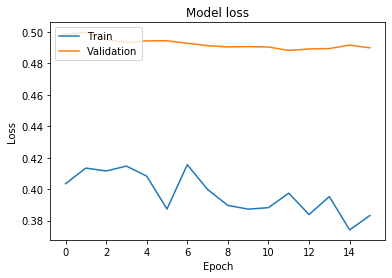

F1 score is:  0.75
Recall score is:  0.76
Precision score is:  0.75
Confusion matrix: 
 [[117  27]
 [ 44 100]]
From the confusion matrix above there are 117 true negatives and 27 false positives.
There are 44 false negatives and 100 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 890ms/step - loss: 0.7142 - acc: 0.4889 - val_loss: 0.7169 - val_acc: 0.4329

Epoch 00001: val_loss improved from inf to 0.71689, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 17s 576ms/step - loss: 0.7068 - acc: 0.4926 - val_loss: 0.7147 - val_acc: 0.4459

Epoch 00002: val_loss improved

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.544407). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 16s 566ms/step - loss: 0.6853 - acc: 0.5492 - val_loss: 0.7046 - val_acc: 0.4762

Epoch 00007: val_loss improved from 0.70661 to 0.70461, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 8/50
29/29 [==============================] - 16s 551ms/step - loss: 0.6886 - acc: 0.5584 - val_loss: 0.7026 - val_acc: 0.4935

Epoch 00008: val_loss improved from 0.70461 to 0.70261, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 9/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6831 - acc: 0.5582 - val_loss: 0.7007 - val_acc: 0.5108

Epoch 00009: val_loss improved from 0.70261 to 0.70067, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 10/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6842 - acc: 0.5606 - val_loss: 0.6989 - val_acc: 0.5152

Epoch 00010: val_loss improved from 0.70067 to 0.69887, saving model to 

Epoch 38/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6099 - acc: 0.6916 - val_loss: 0.6643 - val_acc: 0.5455

Epoch 00038: val_loss improved from 0.66509 to 0.66432, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 39/50
29/29 [==============================] - 16s 542ms/step - loss: 0.5959 - acc: 0.7301 - val_loss: 0.6636 - val_acc: 0.5498

Epoch 00039: val_loss improved from 0.66432 to 0.66362, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 40/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6048 - acc: 0.7204 - val_loss: 0.6628 - val_acc: 0.5541

Epoch 00040: val_loss improved from 0.66362 to 0.66283, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6079 - acc: 0.6969 - val_loss: 0.6622 - val_acc: 0.5584

Epoch 00041: val_loss improved from 0.66283 to 0.66217, sa


Epoch 00018: val_loss improved from 0.63752 to 0.63728, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 19/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5623 - acc: 0.7617 - val_loss: 0.6370 - val_acc: 0.5931

Epoch 00019: val_loss improved from 0.63728 to 0.63703, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 20/50
29/29 [==============================] - 16s 548ms/step - loss: 0.5588 - acc: 0.7506 - val_loss: 0.6360 - val_acc: 0.5974

Epoch 00020: val_loss improved from 0.63703 to 0.63604, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 21/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5453 - acc: 0.7590 - val_loss: 0.6357 - val_acc: 0.5974

Epoch 00021: val_loss improved from 0.63604 to 0.63575, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 22/50
29/29 [==============================] - 16s 5

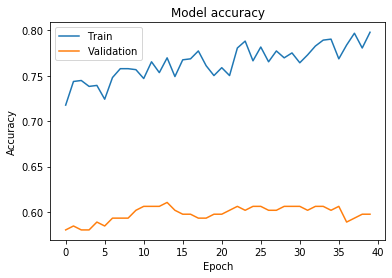

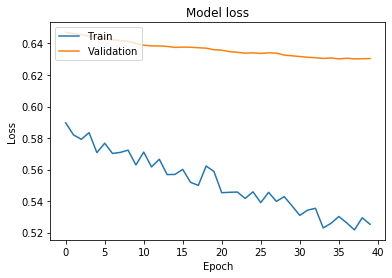

F1 score is:  0.64
Recall score is:  0.73
Precision score is:  0.67
Confusion matrix: 
 [[133  11]
 [ 85  59]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 85 false negatives and 59 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 888ms/step - loss: 0.7240 - acc: 0.4904 - val_loss: 0.6983 - val_acc: 0.5455

Epoch 00001: val_loss improved from inf to 0.69829, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 17s 571ms/step - loss: 0.7287 - acc: 0.4466 - val_loss: 0.6964 - val_acc: 0.5498

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.66197 to 0.66130, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6444 - acc: 0.6447 - val_loss: 0.6603 - val_acc: 0.5628

Epoch 00030: val_loss improved from 0.66130 to 0.66032, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6347 - acc: 0.6656 - val_loss: 0.6593 - val_acc: 0.5628

Epoch 00031: val_loss improved from 0.66032 to 0.65933, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6294 - acc: 0.6657 - val_loss: 0.6585 - val_acc: 0.5584

Epoch 00032: val_loss improved from 0.65933 to 0.65853, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5


Epoch 00012: val_loss improved from 0.64491 to 0.64477, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5824 - acc: 0.7236 - val_loss: 0.6443 - val_acc: 0.5584

Epoch 00013: val_loss improved from 0.64477 to 0.64429, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5670 - acc: 0.7490 - val_loss: 0.6442 - val_acc: 0.5584

Epoch 00014: val_loss improved from 0.64429 to 0.64420, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5812 - acc: 0.7473 - val_loss: 0.6442 - val_acc: 0.5584

Epoch 00015: val_loss did not improve from 0.64420
Epoch 16/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5749 - acc: 0.7441 - val_loss: 0.6437 - val_acc: 0.5628

Epoch 

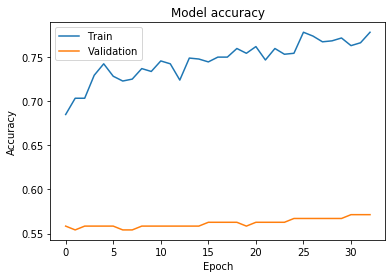

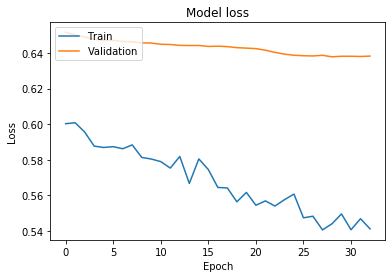

F1 score is:  0.53
Recall score is:  0.72
Precision score is:  0.6
Confusion matrix: 
 [[140   4]
 [112  32]]
From the confusion matrix above there are 140 true negatives and 4 false positives.
There are 112 false negatives and 32 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 894ms/step - loss: 0.7086 - acc: 0.5154 - val_loss: 0.7016 - val_acc: 0.5195

Epoch 00001: val_loss improved from inf to 0.70160, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 559ms/step - loss: 0.6975 - acc: 0.5482 - val_loss: 0.6989 - val_acc: 0.5238

Epoch 00002: val_loss improved f


Epoch 00029: val_loss improved from 0.64566 to 0.64421, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6441 - acc: 0.6318 - val_loss: 0.6428 - val_acc: 0.7100

Epoch 00030: val_loss improved from 0.64421 to 0.64280, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6221 - acc: 0.6627 - val_loss: 0.6416 - val_acc: 0.7056

Epoch 00031: val_loss improved from 0.64280 to 0.64157, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6275 - acc: 0.6691 - val_loss: 0.6401 - val_acc: 0.6926

Epoch 00032: val_loss improved from 0.64157 to 0.64013, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5287 - acc: 0.7787 - val_loss: 0.5875 - val_acc: 0.6970

Epoch 00040: val_loss improved from 0.58792 to 0.58751, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 556ms/step - loss: 0.5239 - acc: 0.7862 - val_loss: 0.5869 - val_acc: 0.7013

Epoch 00041: val_loss improved from 0.58751 to 0.58689, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5323 - acc: 0.7582 - val_loss: 0.5864 - val_acc: 0.6970

Epoch 00042: val_loss improved from 0.58689 to 0.58644, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5274 - acc: 0.7787 - val_loss: 0.5862 - val_acc: 0.6970

Epoch 00043: val_loss improved from 0.58644 to 0.58615, sa

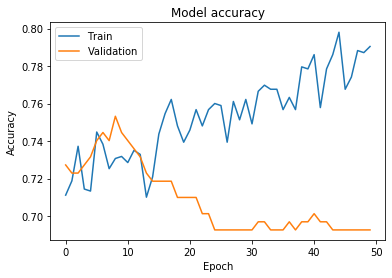

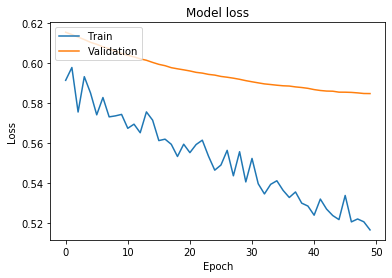

F1 score is:  0.72
Recall score is:  0.75
Precision score is:  0.73
Confusion matrix: 
 [[128  16]
 [ 63  81]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 63 false negatives and 81 true positives. 

Validation score of Ensemble of 1 & 2:  74.03 %
Test score of Ensemble of 1 & 2:  72.57 %
F1 score is:  0.72
Recall score is:  0.74
Precision score is:  0.73
Confusion matrix: 
 [[120  24]
 [ 55  89]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 55 false negatives and 89 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                              65.97                        
3                   

29/29 [==============================] - 8s 287ms/step - loss: 0.5151 - acc: 0.7309 - val_loss: 0.5220 - val_acc: 0.7316

Epoch 00013: val_loss improved from 0.52632 to 0.52198, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 8s 286ms/step - loss: 0.5104 - acc: 0.7565 - val_loss: 0.5184 - val_acc: 0.7273

Epoch 00014: val_loss improved from 0.52198 to 0.51838, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 8s 287ms/step - loss: 0.5078 - acc: 0.7539 - val_loss: 0.5163 - val_acc: 0.7403

Epoch 00015: val_loss improved from 0.51838 to 0.51634, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4998 - acc: 0.7662 - val_loss: 0.5106 - val_acc: 0.7403

Epoch 00016: val_loss improved from 0.51634 to 0.51059, saving model to ./model/ResNet50 FT See


Epoch 00044: val_loss improved from 0.46422 to 0.46275, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3984 - acc: 0.8199 - val_loss: 0.4607 - val_acc: 0.7879

Epoch 00045: val_loss improved from 0.46275 to 0.46073, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 8s 285ms/step - loss: 0.3874 - acc: 0.8270 - val_loss: 0.4602 - val_acc: 0.7879

Epoch 00046: val_loss improved from 0.46073 to 0.46021, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 47/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4021 - acc: 0.8185 - val_loss: 0.4589 - val_acc: 0.7922

Epoch 00047: val_loss improved from 0.46021 to 0.45893, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 48/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3866 - acc: 

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.409216). Check your callbacks.
  % delta_t_median)


11/29 [==========>...................] - ETA: 56s - loss: 0.3771 - acc: 0.8352 

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.364401). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 41s 1s/step - loss: 0.3773 - acc: 0.8224 - val_loss: 0.4556 - val_acc: 0.7879

Epoch 00002: val_loss improved from 0.45572 to 0.45557, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 304ms/step - loss: 0.3873 - acc: 0.8256 - val_loss: 0.4554 - val_acc: 0.7879

Epoch 00003: val_loss improved from 0.45557 to 0.45537, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 295ms/step - loss: 0.3703 - acc: 0.8313 - val_loss: 0.4552 - val_acc: 0.7879

Epoch 00004: val_loss improved from 0.45537 to 0.45518, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 5/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3847 - acc: 0.8245 - val_loss: 0.4547 - val_acc: 0.7922

Epoch 00005: val_loss improved from 0.45518 to 0.45471, saving model to ./model/ResNet50 FT Seed 7 D

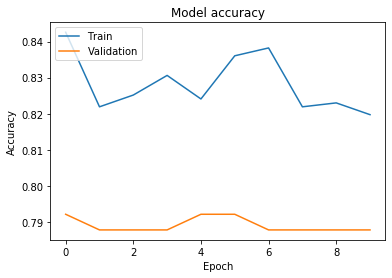

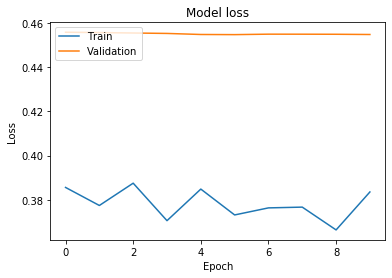

F1 score is:  0.75
Recall score is:  0.75
Precision score is:  0.75
Confusion matrix: 
 [[110  34]
 [ 37 107]]
From the confusion matrix above there are 110 true negatives and 34 false positives.
There are 37 false negatives and 107 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 435ms/step - loss: 0.7976 - acc: 0.4783 - val_loss: 0.7607 - val_acc: 0.4632

Epoch 00001: val_loss improved from inf to 0.76066, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 292ms/step - loss: 0.7639 - acc: 0.4713 - val_loss: 0.7196 - val_acc: 0.4719

Epoch 00002: val_loss improved from 0.76066 to 0.71

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.231231). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 9s 303ms/step - loss: 0.4158 - acc: 0.8097 - val_loss: 0.4622 - val_acc: 0.7662

Epoch 00002: val_loss did not improve from 0.46156
Epoch 3/50
29/29 [==============================] - 9s 293ms/step - loss: 0.4019 - acc: 0.8140 - val_loss: 0.4621 - val_acc: 0.7662

Epoch 00003: val_loss did not improve from 0.46156
Epoch 4/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3943 - acc: 0.8262 - val_loss: 0.4645 - val_acc: 0.7706

Epoch 00004: val_loss did not improve from 0.46156
Epoch 5/50
29/29 [==============================] - 9s 293ms/step - loss: 0.4009 - acc: 0.8280 - val_loss: 0.4659 - val_acc: 0.7749

Epoch 00005: val_loss did not improve from 0.46156
Epoch 00005: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 FT Seed 7 Dropout: 0.3 : Counter: 4, Accuracies: Validation: 77.49 %, Test: 77.08 %


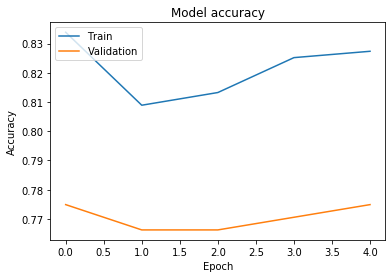

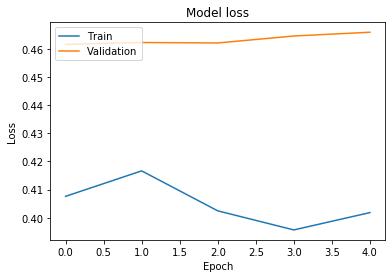

F1 score is:  0.77
Recall score is:  0.78
Precision score is:  0.77
Confusion matrix: 
 [[122  22]
 [ 44 100]]
From the confusion matrix above there are 122 true negatives and 22 false positives.
There are 44 false negatives and 100 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 441ms/step - loss: 0.7956 - acc: 0.5242 - val_loss: 0.7349 - val_acc: 0.5238

Epoch 00001: val_loss improved from inf to 0.73489, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 305ms/step - loss: 0.7561 - acc: 0.5499 - val_loss: 0.7355 - val_acc: 0.5411

Epoch 00002: val_loss did not improve from 0.73489


Epoch 31/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4827 - acc: 0.7654 - val_loss: 0.4908 - val_acc: 0.8225

Epoch 00031: val_loss improved from 0.49251 to 0.49084, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 288ms/step - loss: 0.4736 - acc: 0.7711 - val_loss: 0.4882 - val_acc: 0.8225

Epoch 00032: val_loss improved from 0.49084 to 0.48825, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4594 - acc: 0.7892 - val_loss: 0.4811 - val_acc: 0.8225

Epoch 00033: val_loss improved from 0.48825 to 0.48109, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4611 - acc: 0.7978 - val_loss: 0.4784 - val_acc: 0.8268

Epoch 00034: val_loss improved from 0.48109 to 0.47838, saving model to ./model/Res

Epoch 13/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3899 - acc: 0.8351 - val_loss: 0.4265 - val_acc: 0.8398

Epoch 00013: val_loss improved from 0.42808 to 0.42653, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3899 - acc: 0.8410 - val_loss: 0.4261 - val_acc: 0.8398

Epoch 00014: val_loss improved from 0.42653 to 0.42610, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3721 - acc: 0.8280 - val_loss: 0.4270 - val_acc: 0.8355

Epoch 00015: val_loss did not improve from 0.42610
Epoch 16/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3935 - acc: 0.8253 - val_loss: 0.4304 - val_acc: 0.8355

Epoch 00016: val_loss did not improve from 0.42610
Epoch 17/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3810 - acc: 0.8388 - val_loss: 

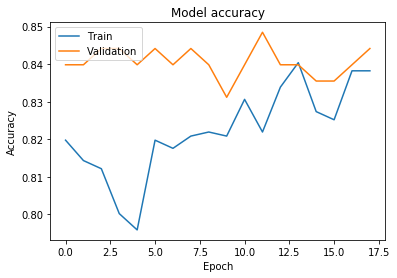

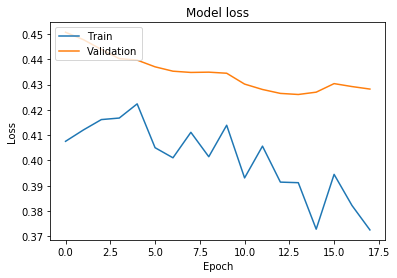

F1 score is:  0.78
Recall score is:  0.78
Precision score is:  0.78
Confusion matrix: 
 [[112  32]
 [ 32 112]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 32 false negatives and 112 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 29s 988ms/step - loss: 0.6931 - acc: 0.5530 - val_loss: 0.7125 - val_acc: 0.4459

Epoch 00001: val_loss improved from inf to 0.71252, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 564ms/step - loss: 0.6869 - acc: 0.5504 - val_loss: 0.7108 - val_acc: 0.4545

Epoch 00002: val_loss improved


Epoch 00029: val_loss improved from 0.67149 to 0.67029, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6238 - acc: 0.6531 - val_loss: 0.6691 - val_acc: 0.6104

Epoch 00030: val_loss improved from 0.67029 to 0.66906, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6182 - acc: 0.6867 - val_loss: 0.6678 - val_acc: 0.6147

Epoch 00031: val_loss improved from 0.66906 to 0.66778, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6187 - acc: 0.6671 - val_loss: 0.6666 - val_acc: 0.6017

Epoch 00032: val_loss improved from 0.66778 to 0.66663, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5275 - acc: 0.7669 - val_loss: 0.6112 - val_acc: 0.6710

Epoch 00040: val_loss improved from 0.61162 to 0.61120, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5261 - acc: 0.7760 - val_loss: 0.6108 - val_acc: 0.6753

Epoch 00041: val_loss improved from 0.61120 to 0.61081, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5227 - acc: 0.7787 - val_loss: 0.6104 - val_acc: 0.6753

Epoch 00042: val_loss improved from 0.61081 to 0.61036, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5153 - acc: 0.7831 - val_loss: 0.6099 - val_acc: 0.6753

Epoch 00043: val_loss improved from 0.61036 to 0.60990, sa

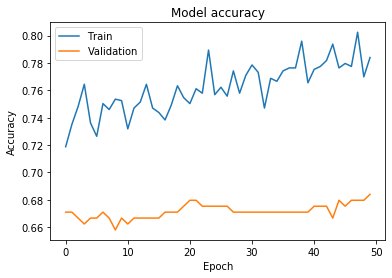

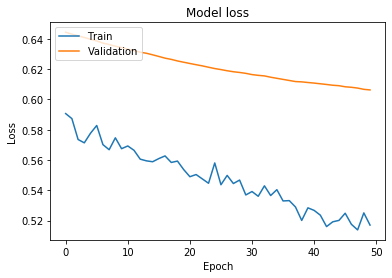

F1 score is:  0.7
Recall score is:  0.73
Precision score is:  0.7
Confusion matrix: 
 [[124  20]
 [ 65  79]]
From the confusion matrix above there are 124 true negatives and 20 false positives.
There are 65 false negatives and 79 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 908ms/step - loss: 0.7039 - acc: 0.5260 - val_loss: 0.7025 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.70252, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 553ms/step - loss: 0.7006 - acc: 0.5090 - val_loss: 0.7012 - val_acc: 0.5065

Epoch 00002: val_loss improved fr


Epoch 00029: val_loss improved from 0.67548 to 0.67482, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6177 - acc: 0.6787 - val_loss: 0.6743 - val_acc: 0.5411

Epoch 00030: val_loss improved from 0.67482 to 0.67427, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6231 - acc: 0.6614 - val_loss: 0.6734 - val_acc: 0.5455

Epoch 00031: val_loss improved from 0.67427 to 0.67336, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6205 - acc: 0.6951 - val_loss: 0.6727 - val_acc: 0.5498

Epoch 00032: val_loss improved from 0.67336 to 0.67275, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5


Epoch 00011: val_loss did not improve from 0.66283
Epoch 12/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5689 - acc: 0.7571 - val_loss: 0.6625 - val_acc: 0.5628

Epoch 00012: val_loss improved from 0.66283 to 0.66248, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 560ms/step - loss: 0.5656 - acc: 0.7353 - val_loss: 0.6628 - val_acc: 0.5628

Epoch 00013: val_loss did not improve from 0.66248
Epoch 14/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5694 - acc: 0.7274 - val_loss: 0.6626 - val_acc: 0.5628

Epoch 00014: val_loss did not improve from 0.66248
Epoch 15/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5620 - acc: 0.7425 - val_loss: 0.6618 - val_acc: 0.5628

Epoch 00015: val_loss improved from 0.66248 to 0.66179, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 16/50
29/29 [===================

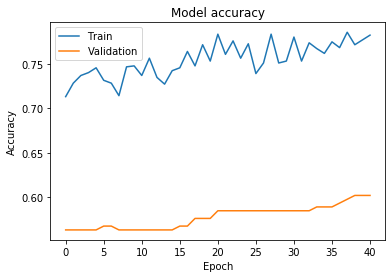

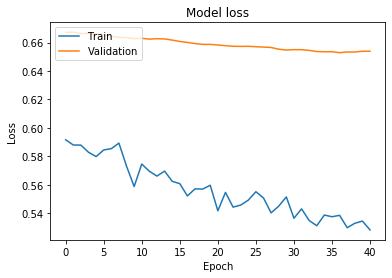

F1 score is:  0.59
Recall score is:  0.72
Precision score is:  0.63
Confusion matrix: 
 [[137   7]
 [100  44]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 100 false negatives and 44 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 25s 869ms/step - loss: 0.7233 - acc: 0.4850 - val_loss: 0.7224 - val_acc: 0.4329

Epoch 00001: val_loss improved from inf to 0.72236, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.7238 - acc: 0.4721 - val_loss: 0.7200 - val_acc: 0.4459

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.67866 to 0.67766, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 541ms/step - loss: 0.6352 - acc: 0.6325 - val_loss: 0.6765 - val_acc: 0.5801

Epoch 00030: val_loss improved from 0.67766 to 0.67654, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 543ms/step - loss: 0.6363 - acc: 0.6262 - val_loss: 0.6755 - val_acc: 0.5844

Epoch 00031: val_loss improved from 0.67654 to 0.67548, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 541ms/step - loss: 0.6387 - acc: 0.6266 - val_loss: 0.6744 - val_acc: 0.5844

Epoch 00032: val_loss improved from 0.67548 to 0.67440, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5


Epoch 00040: val_loss did not improve from 0.63175
Epoch 41/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5341 - acc: 0.7668 - val_loss: 0.6314 - val_acc: 0.6190

Epoch 00041: val_loss improved from 0.63175 to 0.63136, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5389 - acc: 0.7625 - val_loss: 0.6315 - val_acc: 0.6190

Epoch 00042: val_loss did not improve from 0.63136
Epoch 43/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5362 - acc: 0.7636 - val_loss: 0.6312 - val_acc: 0.6190

Epoch 00043: val_loss improved from 0.63136 to 0.63118, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 44/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5305 - acc: 0.7734 - val_loss: 0.6309 - val_acc: 0.6190

Epoch 00044: val_loss improved from 0.63118 to 0.63087, saving model to ./model/Efficient

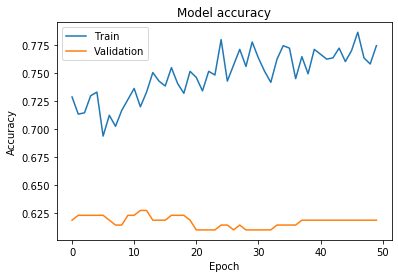

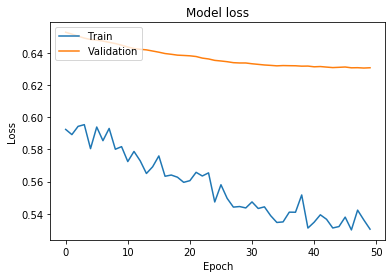

F1 score is:  0.64
Recall score is:  0.71
Precision score is:  0.66
Confusion matrix: 
 [[131  13]
 [ 85  59]]
From the confusion matrix above there are 131 true negatives and 13 false positives.
There are 85 false negatives and 59 true positives. 

Validation score of Ensemble of 1 & 2:  77.92 %
Test score of Ensemble of 1 & 2:  77.43 %
F1 score is:  0.77
Recall score is:  0.78
Precision score is:  0.77
Confusion matrix: 
 [[118  26]
 [ 39 105]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 39 false negatives and 105 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                              65.97                        
3     

Epoch 10/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6243 - acc: 0.6670 - val_loss: 0.6266 - val_acc: 0.6537

Epoch 00010: val_loss improved from 0.63436 to 0.62658, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 11/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6070 - acc: 0.6910 - val_loss: 0.6188 - val_acc: 0.6580

Epoch 00011: val_loss improved from 0.62658 to 0.61883, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 8s 286ms/step - loss: 0.5981 - acc: 0.6899 - val_loss: 0.6114 - val_acc: 0.6667

Epoch 00012: val_loss improved from 0.61883 to 0.61135, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 8s 286ms/step - loss: 0.5898 - acc: 0.6996 - val_loss: 0.6026 - val_acc: 0.6710

Epoch 00013: val_loss improved from 0.61135 to 0.60258, saving model to ./model/Res


Epoch 00041: val_loss improved from 0.47045 to 0.46845, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4069 - acc: 0.8223 - val_loss: 0.4665 - val_acc: 0.7576

Epoch 00042: val_loss improved from 0.46845 to 0.46648, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3986 - acc: 0.8233 - val_loss: 0.4644 - val_acc: 0.7662

Epoch 00043: val_loss improved from 0.46648 to 0.46437, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 44/50
29/29 [==============================] - 8s 288ms/step - loss: 0.4111 - acc: 0.8258 - val_loss: 0.4620 - val_acc: 0.7662

Epoch 00044: val_loss improved from 0.46437 to 0.46204, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 8s 286ms/step - loss: 0.3992 - acc: 


Epoch 00023: val_loss improved from 0.42708 to 0.42684, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 24/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3427 - acc: 0.8706 - val_loss: 0.4261 - val_acc: 0.8009

Epoch 00024: val_loss improved from 0.42684 to 0.42608, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 25/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3336 - acc: 0.8571 - val_loss: 0.4256 - val_acc: 0.7922

Epoch 00025: val_loss improved from 0.42608 to 0.42562, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 26/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3378 - acc: 0.8746 - val_loss: 0.4249 - val_acc: 0.8009

Epoch 00026: val_loss improved from 0.42562 to 0.42486, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 27/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3354 - acc: 

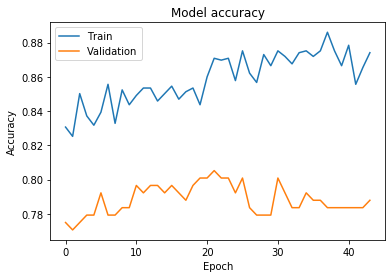

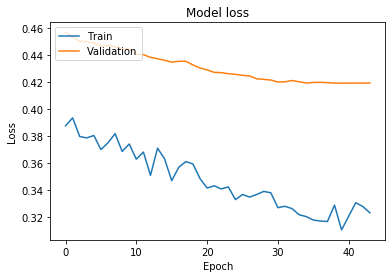

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[112  32]
 [ 42 102]]
From the confusion matrix above there are 112 true negatives and 32 false positives.
There are 42 false negatives and 102 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 444ms/step - loss: 0.7999 - acc: 0.4980 - val_loss: 0.7306 - val_acc: 0.5238

Epoch 00001: val_loss improved from inf to 0.73065, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 303ms/step - loss: 0.7346 - acc: 0.5418 - val_loss: 0.6932 - val_acc: 0.5758

Epoch 00002: val_loss improved from 0.73065 to 0.69

Epoch 31/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4419 - acc: 0.8061 - val_loss: 0.4457 - val_acc: 0.7749

Epoch 00031: val_loss improved from 0.44711 to 0.44566, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4483 - acc: 0.7864 - val_loss: 0.4450 - val_acc: 0.7749

Epoch 00032: val_loss improved from 0.44566 to 0.44498, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 285ms/step - loss: 0.4356 - acc: 0.8123 - val_loss: 0.4411 - val_acc: 0.7792

Epoch 00033: val_loss improved from 0.44498 to 0.44112, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4447 - acc: 0.8042 - val_loss: 0.4408 - val_acc: 0.7749

Epoch 00034: val_loss improved from 0.44112 to 0.44077, saving model to ./model/Res


Epoch 00013: val_loss did not improve from 0.40725
Epoch 14/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3774 - acc: 0.8387 - val_loss: 0.4070 - val_acc: 0.8052

Epoch 00014: val_loss improved from 0.40725 to 0.40703, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3769 - acc: 0.8333 - val_loss: 0.4104 - val_acc: 0.8052

Epoch 00015: val_loss did not improve from 0.40703
Epoch 16/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3738 - acc: 0.8481 - val_loss: 0.4087 - val_acc: 0.8052

Epoch 00016: val_loss did not improve from 0.40703
Epoch 17/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3650 - acc: 0.8336 - val_loss: 0.4101 - val_acc: 0.8139

Epoch 00017: val_loss did not improve from 0.40703
Epoch 18/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3736 - acc: 0.8326 - val_loss: 0.4098 - val_acc: 0.8139

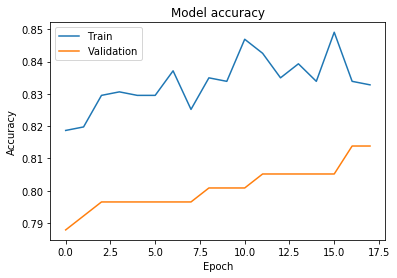

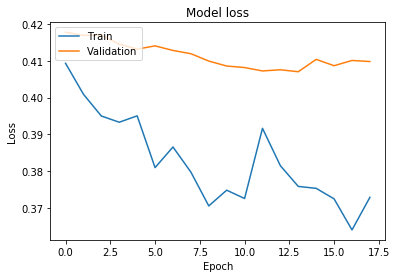

F1 score is:  0.79
Recall score is:  0.79
Precision score is:  0.79
Confusion matrix: 
 [[120  24]
 [ 37 107]]
From the confusion matrix above there are 120 true negatives and 24 false positives.
There are 37 false negatives and 107 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 15s 515ms/step - loss: 0.7083 - acc: 0.5848 - val_loss: 0.6334 - val_acc: 0.6364

Epoch 00001: val_loss improved from inf to 0.63336, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 11s 362ms/step - loss: 0.7162 - acc: 0.5972 - val_loss: 0.6193 - val_acc: 0.6450

Epoch 00002: val_loss improved from 0.63336 to 0.6

Epoch 11/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3951 - acc: 0.8379 - val_loss: 0.4051 - val_acc: 0.8095

Epoch 00011: val_loss improved from 0.40577 to 0.40507, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3866 - acc: 0.8315 - val_loss: 0.4039 - val_acc: 0.8052

Epoch 00012: val_loss improved from 0.40507 to 0.40395, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3863 - acc: 0.8220 - val_loss: 0.4034 - val_acc: 0.8052

Epoch 00013: val_loss improved from 0.40395 to 0.40336, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3949 - acc: 0.8352 - val_loss: 0.4024 - val_acc: 0.8009

Epoch 00014: val_loss improved from 0.40336 to 0.40242, saving model to ./model/Res

Epoch 44/50
29/29 [==============================] - 8s 291ms/step - loss: 0.3495 - acc: 0.8390 - val_loss: 0.3849 - val_acc: 0.8225

Epoch 00044: val_loss improved from 0.38527 to 0.38487, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 45/50
29/29 [==============================] - 9s 318ms/step - loss: 0.3442 - acc: 0.8535 - val_loss: 0.3843 - val_acc: 0.8268

Epoch 00045: val_loss improved from 0.38487 to 0.38430, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 46/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3295 - acc: 0.8573 - val_loss: 0.3842 - val_acc: 0.8268

Epoch 00046: val_loss improved from 0.38430 to 0.38422, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 47/50
29/29 [==============================] - 10s 351ms/step - loss: 0.3416 - acc: 0.8466 - val_loss: 0.3841 - val_acc: 0.8182

Epoch 00047: val_loss improved from 0.38422 to 0.38409, saving model to ./model/Re

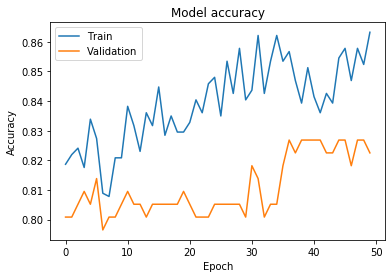

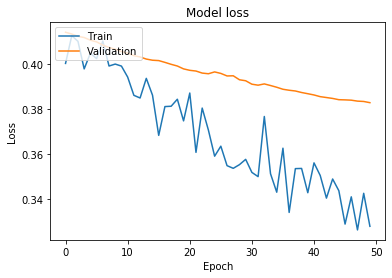

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[107  37]
 [ 38 106]]
From the confusion matrix above there are 107 true negatives and 37 false positives.
There are 38 false negatives and 106 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 37s 1s/step - loss: 0.7118 - acc: 0.4834 - val_loss: 0.7355 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.73547, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 17s 576ms/step - loss: 0.6999 - acc: 0.5317 - val_loss: 0.7322 - val_acc: 0.5022

Epoch 00002: val_loss improved fr


Epoch 00029: val_loss improved from 0.66300 to 0.66107, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 543ms/step - loss: 0.6348 - acc: 0.6619 - val_loss: 0.6592 - val_acc: 0.6234

Epoch 00030: val_loss improved from 0.66107 to 0.65923, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 542ms/step - loss: 0.6342 - acc: 0.6522 - val_loss: 0.6573 - val_acc: 0.6407

Epoch 00031: val_loss improved from 0.65923 to 0.65734, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 542ms/step - loss: 0.6237 - acc: 0.6831 - val_loss: 0.6556 - val_acc: 0.6407

Epoch 00032: val_loss improved from 0.65734 to 0.65558, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5313 - acc: 0.7872 - val_loss: 0.5889 - val_acc: 0.6883

Epoch 00040: val_loss improved from 0.58919 to 0.58894, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5264 - acc: 0.7796 - val_loss: 0.5883 - val_acc: 0.6883

Epoch 00041: val_loss improved from 0.58894 to 0.58827, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5405 - acc: 0.7549 - val_loss: 0.5875 - val_acc: 0.6926

Epoch 00042: val_loss improved from 0.58827 to 0.58748, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5438 - acc: 0.7546 - val_loss: 0.5869 - val_acc: 0.6970

Epoch 00043: val_loss improved from 0.58748 to 0.58693, sa

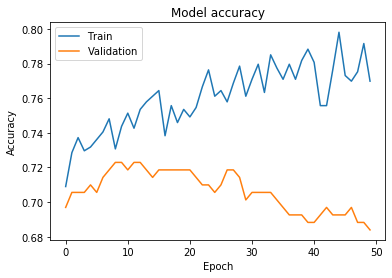

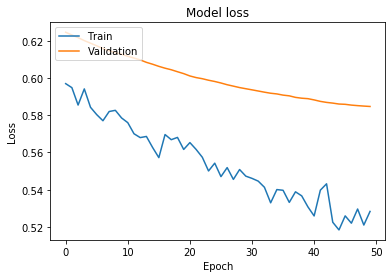

F1 score is:  0.73
Recall score is:  0.77
Precision score is:  0.74
Confusion matrix: 
 [[132  12]
 [ 64  80]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 64 false negatives and 80 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 906ms/step - loss: 0.7201 - acc: 0.4698 - val_loss: 0.7490 - val_acc: 0.4286

Epoch 00001: val_loss improved from inf to 0.74901, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 545ms/step - loss: 0.7049 - acc: 0.5139 - val_loss: 0.7462 - val_acc: 0.4286

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.69021 to 0.68872, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6525 - acc: 0.6363 - val_loss: 0.6873 - val_acc: 0.5455

Epoch 00030: val_loss improved from 0.68872 to 0.68727, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6425 - acc: 0.6405 - val_loss: 0.6858 - val_acc: 0.5498

Epoch 00031: val_loss improved from 0.68727 to 0.68584, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6403 - acc: 0.6579 - val_loss: 0.6844 - val_acc: 0.5498

Epoch 00032: val_loss improved from 0.68584 to 0.68436, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5374 - acc: 0.7862 - val_loss: 0.6225 - val_acc: 0.6190

Epoch 00040: val_loss improved from 0.62326 to 0.62253, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5316 - acc: 0.7636 - val_loss: 0.6219 - val_acc: 0.6234

Epoch 00041: val_loss improved from 0.62253 to 0.62189, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5424 - acc: 0.7658 - val_loss: 0.6216 - val_acc: 0.6234

Epoch 00042: val_loss improved from 0.62189 to 0.62159, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 556ms/step - loss: 0.5434 - acc: 0.7525 - val_loss: 0.6212 - val_acc: 0.6234

Epoch 00043: val_loss improved from 0.62159 to 0.62123, sa

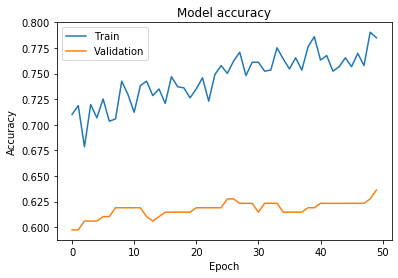

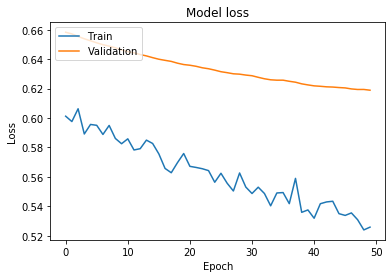

F1 score is:  0.71
Recall score is:  0.75
Precision score is:  0.72
Confusion matrix: 
 [[129  15]
 [ 66  78]]
From the confusion matrix above there are 129 true negatives and 15 false positives.
There are 66 false negatives and 78 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 898ms/step - loss: 0.7171 - acc: 0.4964 - val_loss: 0.7105 - val_acc: 0.4675

Epoch 00001: val_loss improved from inf to 0.71048, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 546ms/step - loss: 0.7122 - acc: 0.5292 - val_loss: 0.7083 - val_acc: 0.4632

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.66534 to 0.66415, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6372 - acc: 0.6425 - val_loss: 0.6628 - val_acc: 0.5887

Epoch 00030: val_loss improved from 0.66415 to 0.66284, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6296 - acc: 0.6512 - val_loss: 0.6617 - val_acc: 0.5887

Epoch 00031: val_loss improved from 0.66284 to 0.66170, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6350 - acc: 0.6543 - val_loss: 0.6607 - val_acc: 0.5887

Epoch 00032: val_loss improved from 0.66170 to 0.66065, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

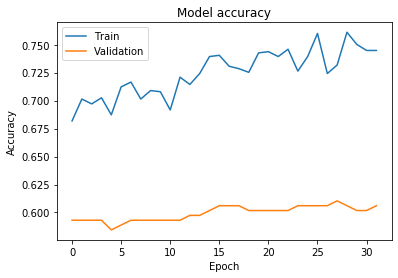

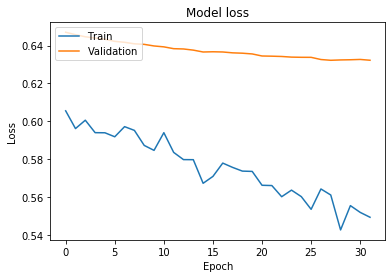

F1 score is:  0.61
Recall score is:  0.73
Precision score is:  0.65
Confusion matrix: 
 [[137   7]
 [ 95  49]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 95 false negatives and 49 true positives. 

Validation score of Ensemble of 1 & 2:  82.25 %
Test score of Ensemble of 1 & 2:  79.51 %
F1 score is:  0.79
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[121  23]
 [ 36 108]]
From the confusion matrix above there are 121 true negatives and 23 false positives.
There are 36 false negatives and 108 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   
5       5   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                              65.97                     

29/29 [==============================] - 8s 287ms/step - loss: 0.3988 - acc: 0.8464 - val_loss: 0.6405 - val_acc: 0.6580

Epoch 00042: val_loss did not improve from 0.63712
Epoch 43/50
29/29 [==============================] - 8s 287ms/step - loss: 0.3990 - acc: 0.8253 - val_loss: 0.6402 - val_acc: 0.6580

Epoch 00043: val_loss did not improve from 0.63712
Epoch 00043: early stopping

 ResNet50 FT Seed 7 Dropout: 0.2 : Counter: 6, Testing Accuracy: 61.46 % 


 
 ############################################### 
 
 Retraining with last conv layer unfrozen 
 
Epoch 1/50
29/29 [==============================] - 13s 448ms/step - loss: 0.4017 - acc: 0.8224 - val_loss: 0.6311 - val_acc: 0.6580

Epoch 00001: val_loss improved from 0.63712 to 0.63107, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3839 - acc: 0.8359 - val_loss: 0.6301 - val_acc: 0.6580

Epoch 00002: val_loss improved from 0.63107 

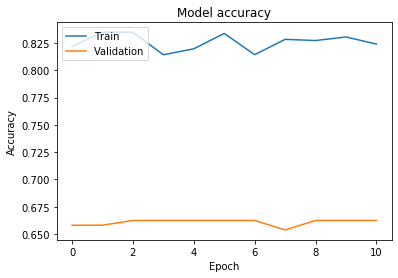

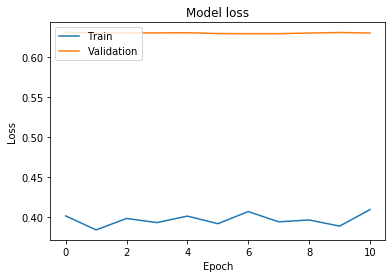

F1 score is:  0.57
Recall score is:  0.68
Precision score is:  0.61
Confusion matrix: 
 [[132  12]
 [100  44]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 100 false negatives and 44 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 419ms/step - loss: 0.8534 - acc: 0.4530 - val_loss: 0.8238 - val_acc: 0.4892

Epoch 00001: val_loss improved from inf to 0.82379, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 285ms/step - loss: 0.7792 - acc: 0.4926 - val_loss: 0.7749 - val_acc: 0.5022

Epoch 00002: val_loss improved from 0.82379 to 0.77


Epoch 00031: val_loss improved from 0.55773 to 0.55103, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4460 - acc: 0.7965 - val_loss: 0.5476 - val_acc: 0.6883

Epoch 00032: val_loss improved from 0.55103 to 0.54763, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4498 - acc: 0.7913 - val_loss: 0.5441 - val_acc: 0.6926

Epoch 00033: val_loss improved from 0.54763 to 0.54406, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4365 - acc: 0.7984 - val_loss: 0.5391 - val_acc: 0.6970

Epoch 00034: val_loss improved from 0.54406 to 0.53914, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4318 - acc: 

29/29 [==============================] - 9s 294ms/step - loss: 0.4079 - acc: 0.8261 - val_loss: 0.5122 - val_acc: 0.7186

Epoch 00016: val_loss did not improve from 0.51198
Epoch 17/50
29/29 [==============================] - 9s 294ms/step - loss: 0.4049 - acc: 0.8350 - val_loss: 0.5122 - val_acc: 0.7186

Epoch 00017: val_loss did not improve from 0.51198
Epoch 00017: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 FT Seed 7 Dropout: 0.3 : Counter: 6, Accuracies: Validation: 71.86 %, Test: 76.39 %


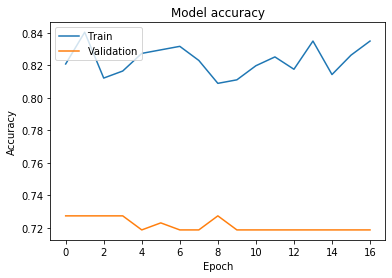

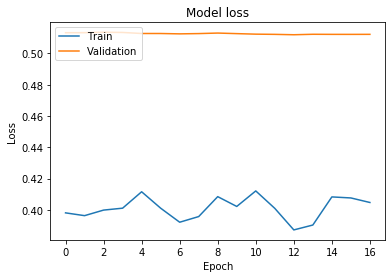

F1 score is:  0.76
Recall score is:  0.79
Precision score is:  0.76
Confusion matrix: 
 [[131  13]
 [ 55  89]]
From the confusion matrix above there are 131 true negatives and 13 false positives.
There are 55 false negatives and 89 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 24s 820ms/step - loss: 0.7283 - acc: 0.5681 - val_loss: 0.6738 - val_acc: 0.6104

Epoch 00001: val_loss improved from inf to 0.67381, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 14s 478ms/step - loss: 0.7258 - acc: 0.5675 - val_loss: 0.6485 - val_acc: 0.6104

Epoch 00002: val_loss improved from 0.67381 to 0.64


Epoch 00011: val_loss improved from 0.41707 to 0.41633, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 12/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3912 - acc: 0.8251 - val_loss: 0.4158 - val_acc: 0.8268

Epoch 00012: val_loss improved from 0.41633 to 0.41583, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3860 - acc: 0.8305 - val_loss: 0.4165 - val_acc: 0.8095

Epoch 00013: val_loss did not improve from 0.41583
Epoch 14/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3765 - acc: 0.8412 - val_loss: 0.4135 - val_acc: 0.8312

Epoch 00014: val_loss improved from 0.41583 to 0.41350, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3926 - acc: 0.8313 - val_loss: 0.4123 - val_acc: 0.8268

Epoch 00015: val_loss improved 

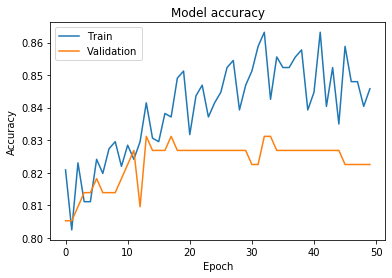

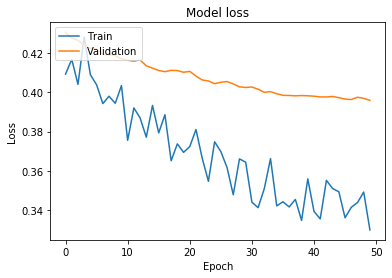

F1 score is:  0.8
Recall score is:  0.8
Precision score is:  0.8
Confusion matrix: 
 [[119  25]
 [ 32 112]]
From the confusion matrix above there are 119 true negatives and 25 false positives.
There are 32 false negatives and 112 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 40s 1s/step - loss: 0.6928 - acc: 0.5266 - val_loss: 0.7038 - val_acc: 0.5325

Epoch 00001: val_loss improved from inf to 0.70380, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 18s 629ms/step - loss: 0.6989 - acc: 0.5250 - val_loss: 0.7016 - val_acc: 0.5368

Epoch 00002: val_loss improved from 


Epoch 00029: val_loss improved from 0.65768 to 0.65636, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6247 - acc: 0.6856 - val_loss: 0.6550 - val_acc: 0.6147

Epoch 00030: val_loss improved from 0.65636 to 0.65500, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6318 - acc: 0.6563 - val_loss: 0.6538 - val_acc: 0.6190

Epoch 00031: val_loss improved from 0.65500 to 0.65377, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6179 - acc: 0.6859 - val_loss: 0.6526 - val_acc: 0.6190

Epoch 00032: val_loss improved from 0.65377 to 0.65261, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5335 - acc: 0.7700 - val_loss: 0.6009 - val_acc: 0.6494

Epoch 00040: val_loss improved from 0.60141 to 0.60085, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5299 - acc: 0.7759 - val_loss: 0.6005 - val_acc: 0.6494

Epoch 00041: val_loss improved from 0.60085 to 0.60049, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5267 - acc: 0.7749 - val_loss: 0.6000 - val_acc: 0.6494

Epoch 00042: val_loss improved from 0.60049 to 0.60001, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5337 - acc: 0.7776 - val_loss: 0.5997 - val_acc: 0.6494

Epoch 00043: val_loss improved from 0.60001 to 0.59966, sa

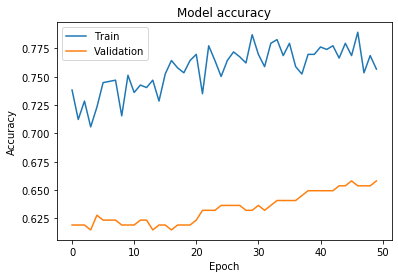

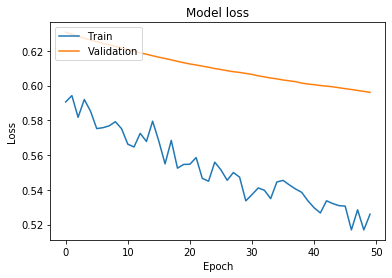

F1 score is:  0.71
Recall score is:  0.72
Precision score is:  0.71
Confusion matrix: 
 [[118  26]
 [ 57  87]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 57 false negatives and 87 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 885ms/step - loss: 0.7389 - acc: 0.4400 - val_loss: 0.7582 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.75823, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 554ms/step - loss: 0.7421 - acc: 0.4190 - val_loss: 0.7565 - val_acc: 0.4848

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.72673 to 0.72599, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6545 - acc: 0.6164 - val_loss: 0.7254 - val_acc: 0.5022

Epoch 00030: val_loss improved from 0.72599 to 0.72541, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 550ms/step - loss: 0.6550 - acc: 0.6358 - val_loss: 0.7245 - val_acc: 0.5022

Epoch 00031: val_loss improved from 0.72541 to 0.72447, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6383 - acc: 0.6404 - val_loss: 0.7234 - val_acc: 0.5022

Epoch 00032: val_loss improved from 0.72447 to 0.72342, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

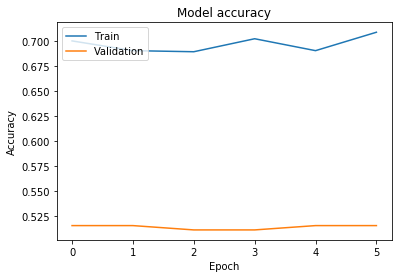

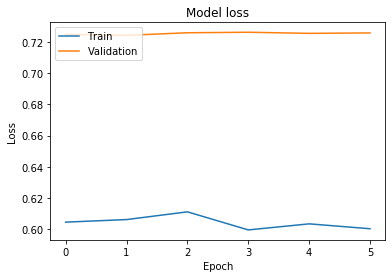

F1 score is:  0.34
Recall score is:  0.5
Precision score is:  0.5
Confusion matrix: 
 [[143   1]
 [143   1]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 143 false negatives and 1 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 889ms/step - loss: 0.7159 - acc: 0.5110 - val_loss: 0.7265 - val_acc: 0.4805

Epoch 00001: val_loss improved from inf to 0.72650, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.7059 - acc: 0.5204 - val_loss: 0.7243 - val_acc: 0.4935

Epoch 00002: val_loss improved fro


Epoch 00029: val_loss improved from 0.67633 to 0.67475, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6231 - acc: 0.6659 - val_loss: 0.6732 - val_acc: 0.5931

Epoch 00030: val_loss improved from 0.67475 to 0.67324, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6317 - acc: 0.6477 - val_loss: 0.6718 - val_acc: 0.6017

Epoch 00031: val_loss improved from 0.67324 to 0.67183, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6246 - acc: 0.6641 - val_loss: 0.6706 - val_acc: 0.6017

Epoch 00032: val_loss improved from 0.67183 to 0.67057, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5376 - acc: 0.7551 - val_loss: 0.6053 - val_acc: 0.6926

Epoch 00040: val_loss improved from 0.60620 to 0.60534, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5312 - acc: 0.7534 - val_loss: 0.6046 - val_acc: 0.6970

Epoch 00041: val_loss improved from 0.60534 to 0.60455, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5286 - acc: 0.7657 - val_loss: 0.6039 - val_acc: 0.6970

Epoch 00042: val_loss improved from 0.60455 to 0.60394, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5283 - acc: 0.7633 - val_loss: 0.6032 - val_acc: 0.6970

Epoch 00043: val_loss improved from 0.60394 to 0.60316, sa

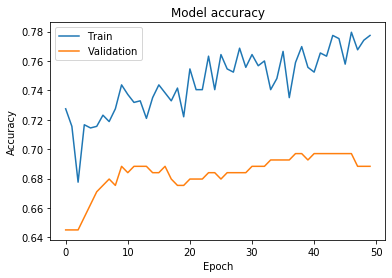

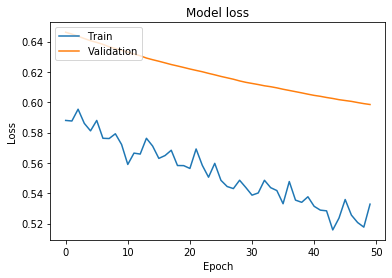

F1 score is:  0.74
Recall score is:  0.74
Precision score is:  0.74
Confusion matrix: 
 [[108  36]
 [ 39 105]]
From the confusion matrix above there are 108 true negatives and 36 false positives.
There are 39 false negatives and 105 true positives. 

Validation score of Ensemble of 1 & 2:  67.1 %
Test score of Ensemble of 1 & 2:  69.1 %
F1 score is:  0.67
Recall score is:  0.74
Precision score is:  0.69
Confusion matrix: 
 [[132  12]
 [ 77  67]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 77 false negatives and 67 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   
5       5   
6       6   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                              65.97       

Epoch 4/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6835 - acc: 0.5932 - val_loss: 0.7449 - val_acc: 0.5022

Epoch 00004: val_loss improved from 0.77044 to 0.74494, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 5/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6579 - acc: 0.5964 - val_loss: 0.7219 - val_acc: 0.5238

Epoch 00005: val_loss improved from 0.74494 to 0.72194, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 6/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6402 - acc: 0.6178 - val_loss: 0.7026 - val_acc: 0.5455

Epoch 00006: val_loss improved from 0.72194 to 0.70258, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 7/50
29/29 [==============================] - 8s 285ms/step - loss: 0.6329 - acc: 0.6239 - val_loss: 0.6844 - val_acc: 0.5801

Epoch 00007: val_loss improved from 0.70258 to 0.68436, saving model to ./model/ResNet5


Epoch 00035: val_loss improved from 0.48955 to 0.48853, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 36/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4397 - acc: 0.8032 - val_loss: 0.4856 - val_acc: 0.7489

Epoch 00036: val_loss improved from 0.48853 to 0.48557, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 37/50
29/29 [==============================] - 9s 308ms/step - loss: 0.4345 - acc: 0.8054 - val_loss: 0.4819 - val_acc: 0.7532

Epoch 00037: val_loss improved from 0.48557 to 0.48188, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 38/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4263 - acc: 0.8005 - val_loss: 0.4805 - val_acc: 0.7532

Epoch 00038: val_loss improved from 0.48188 to 0.48053, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 39/50
29/29 [==============================] - 8s 285ms/step - loss: 0.4198 - acc: 

Epoch 18/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3580 - acc: 0.8607 - val_loss: 0.4469 - val_acc: 0.7619

Epoch 00018: val_loss did not improve from 0.44594
Epoch 19/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3570 - acc: 0.8467 - val_loss: 0.4454 - val_acc: 0.7662

Epoch 00019: val_loss improved from 0.44594 to 0.44536, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 20/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3553 - acc: 0.8582 - val_loss: 0.4448 - val_acc: 0.7662

Epoch 00020: val_loss improved from 0.44536 to 0.44476, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 21/50
29/29 [==============================] - 8s 292ms/step - loss: 0.3606 - acc: 0.8488 - val_loss: 0.4447 - val_acc: 0.7619

Epoch 00021: val_loss improved from 0.44476 to 0.44469, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 22/50
29/29 [=============

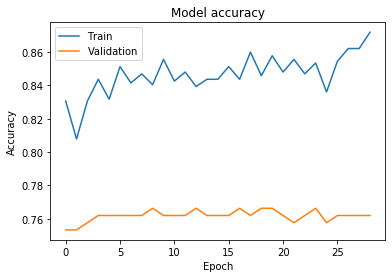

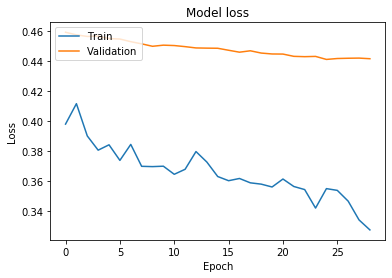

F1 score is:  0.77
Recall score is:  0.78
Precision score is:  0.77
Confusion matrix: 
 [[118  26]
 [ 39 105]]
From the confusion matrix above there are 118 true negatives and 26 false positives.
There are 39 false negatives and 105 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 12s 421ms/step - loss: 0.7448 - acc: 0.5278 - val_loss: 0.8039 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.80390, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 290ms/step - loss: 0.7100 - acc: 0.5435 - val_loss: 0.7641 - val_acc: 0.5065

Epoch 00002: val_loss improved from 0.80390 to 0.76

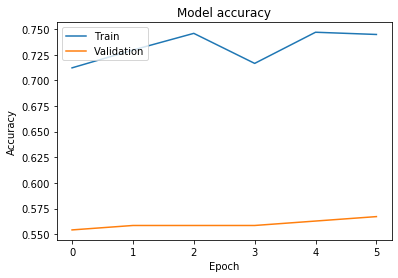

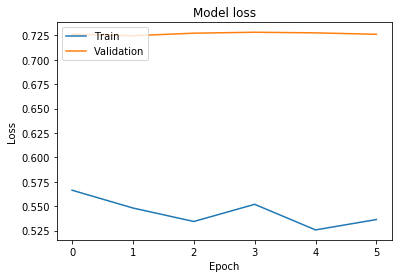

F1 score is:  0.45
Recall score is:  0.69
Precision score is:  0.55
Confusion matrix: 
 [[141   3]
 [127  17]]
From the confusion matrix above there are 141 true negatives and 3 false positives.
There are 127 false negatives and 17 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 434ms/step - loss: 0.8400 - acc: 0.5021 - val_loss: 1.1357 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 1.13571, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 285ms/step - loss: 0.7611 - acc: 0.5220 - val_loss: 1.0216 - val_acc: 0.5022

Epoch 00002: val_loss improved from 1.13571 to 1.021


Epoch 00031: val_loss did not improve from 0.67305
Epoch 32/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4377 - acc: 0.8053 - val_loss: 0.6591 - val_acc: 0.6147

Epoch 00032: val_loss improved from 0.67305 to 0.65914, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4620 - acc: 0.7771 - val_loss: 0.6589 - val_acc: 0.6190

Epoch 00033: val_loss improved from 0.65914 to 0.65892, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4605 - acc: 0.7930 - val_loss: 0.6584 - val_acc: 0.6234

Epoch 00034: val_loss improved from 0.65892 to 0.65844, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 35/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4447 - acc: 0.7830 - val_loss: 0.6463 - val_acc: 0.6450

Epoch 00035: val_loss improved 


Epoch 00017: val_loss did not improve from 0.59851
Epoch 00017: early stopping
validating_size 231 val_preds (231, 2) y_val:  (231, 2)
ResNet50 FT Seed 7 Dropout: 0.4 : Counter: 7, Accuracies: Validation: 69.26 %, Test: 67.36 %


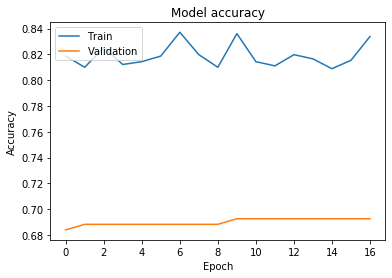

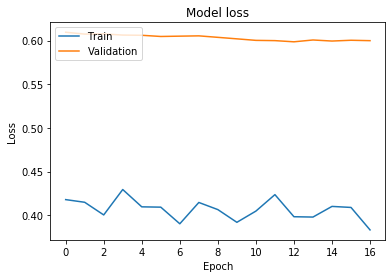

F1 score is:  0.65
Recall score is:  0.73
Precision score is:  0.67
Confusion matrix: 
 [[132  12]
 [ 82  62]]
From the confusion matrix above there are 132 true negatives and 12 false positives.
There are 82 false negatives and 62 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 882ms/step - loss: 0.7120 - acc: 0.4972 - val_loss: 0.6799 - val_acc: 0.5498

Epoch 00001: val_loss improved from inf to 0.67986, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6931 - acc: 0.5487 - val_loss: 0.6784 - val_acc: 0.5541

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.64686 to 0.64615, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6210 - acc: 0.6914 - val_loss: 0.6455 - val_acc: 0.6147

Epoch 00030: val_loss improved from 0.64615 to 0.64551, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6200 - acc: 0.6730 - val_loss: 0.6445 - val_acc: 0.6190

Epoch 00031: val_loss improved from 0.64551 to 0.64455, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6245 - acc: 0.6698 - val_loss: 0.6436 - val_acc: 0.6147

Epoch 00032: val_loss improved from 0.64455 to 0.64358, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5


Epoch 00012: val_loss improved from 0.63053 to 0.62984, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 13/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5575 - acc: 0.7593 - val_loss: 0.6292 - val_acc: 0.6364

Epoch 00013: val_loss improved from 0.62984 to 0.62925, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 14/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5609 - acc: 0.7385 - val_loss: 0.6282 - val_acc: 0.6364

Epoch 00014: val_loss improved from 0.62925 to 0.62816, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5751 - acc: 0.7355 - val_loss: 0.6275 - val_acc: 0.6407

Epoch 00015: val_loss improved from 0.62816 to 0.62751, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 16s 5

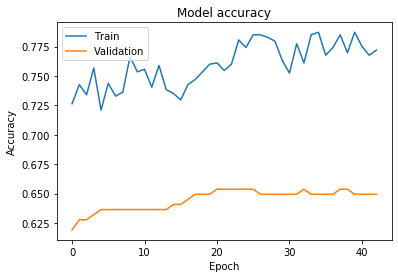

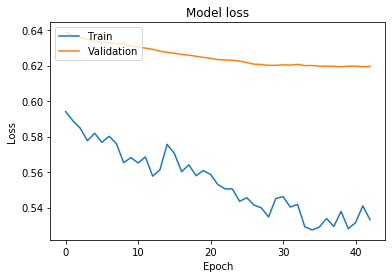

F1 score is:  0.66
Recall score is:  0.76
Precision score is:  0.68
Confusion matrix: 
 [[137   7]
 [ 84  60]]
From the confusion matrix above there are 137 true negatives and 7 false positives.
There are 84 false negatives and 60 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 37s 1s/step - loss: 0.7134 - acc: 0.5076 - val_loss: 0.7182 - val_acc: 0.4589

Epoch 00001: val_loss improved from inf to 0.71822, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 561ms/step - loss: 0.7182 - acc: 0.4949 - val_loss: 0.7166 - val_acc: 0.4589

Epoch 00002: val_loss improved from


Epoch 00029: val_loss improved from 0.68218 to 0.68115, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6430 - acc: 0.6474 - val_loss: 0.6802 - val_acc: 0.5455

Epoch 00030: val_loss improved from 0.68115 to 0.68016, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6498 - acc: 0.6229 - val_loss: 0.6792 - val_acc: 0.5411

Epoch 00031: val_loss improved from 0.68016 to 0.67918, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6404 - acc: 0.6403 - val_loss: 0.6782 - val_acc: 0.5368

Epoch 00032: val_loss improved from 0.67918 to 0.67821, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 41/50
29/29 [==============================] - 16s 549ms/step - loss: 0.5421 - acc: 0.7708 - val_loss: 0.6390 - val_acc: 0.6017

Epoch 00041: val_loss improved from 0.63934 to 0.63896, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5536 - acc: 0.7468 - val_loss: 0.6387 - val_acc: 0.6017

Epoch 00042: val_loss improved from 0.63896 to 0.63866, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5390 - acc: 0.7646 - val_loss: 0.6384 - val_acc: 0.6061

Epoch 00043: val_loss improved from 0.63866 to 0.63839, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 44/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5251 - acc: 0.7797 - val_loss: 0.6383 - val_acc: 0.6061

Epoch 00044: val_loss improved from 0.63839 to 0.63831, sa

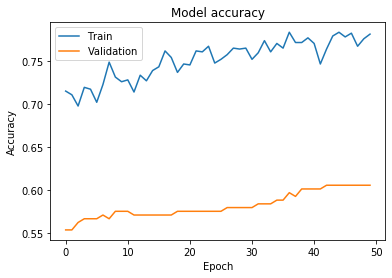

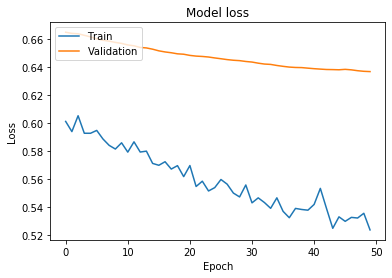

F1 score is:  0.61
Recall score is:  0.71
Precision score is:  0.64
Confusion matrix: 
 [[133  11]
 [ 92  52]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 92 false negatives and 52 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 885ms/step - loss: 0.7161 - acc: 0.4826 - val_loss: 0.6896 - val_acc: 0.5325

Epoch 00001: val_loss improved from inf to 0.68961, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 546ms/step - loss: 0.7073 - acc: 0.5179 - val_loss: 0.6878 - val_acc: 0.5368

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.65305 to 0.65190, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6530 - acc: 0.6245 - val_loss: 0.6510 - val_acc: 0.6061

Epoch 00030: val_loss improved from 0.65190 to 0.65096, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6454 - acc: 0.6231 - val_loss: 0.6501 - val_acc: 0.6190

Epoch 00031: val_loss improved from 0.65096 to 0.65005, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6284 - acc: 0.6530 - val_loss: 0.6492 - val_acc: 0.6190

Epoch 00032: val_loss improved from 0.65005 to 0.64921, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

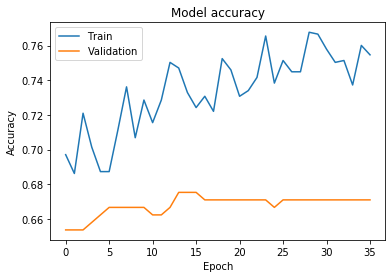

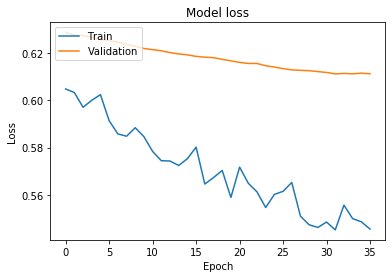

F1 score is:  0.67
Recall score is:  0.75
Precision score is:  0.69
Confusion matrix: 
 [[134  10]
 [ 80  64]]
From the confusion matrix above there are 134 true negatives and 10 false positives.
There are 80 false negatives and 64 true positives. 

Validation score of Ensemble of 1 & 2:  73.59 %
Test score of Ensemble of 1 & 2:  73.61 %
F1 score is:  0.73
Recall score is:  0.78
Precision score is:  0.74
Confusion matrix: 
 [[134  10]
 [ 66  78]]
From the confusion matrix above there are 134 true negatives and 10 false positives.
There are 66 false negatives and 78 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   
5       5   
6       6   
7       7   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                                            

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 15s 503ms/step - loss: 0.7313 - acc: 0.5234 - val_loss: 0.6465 - val_acc: 0.6190

Epoch 00001: val_loss improved from inf to 0.64654, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 10s 331ms/step - loss: 0.7017 - acc: 0.5690 - val_loss: 0.6324 - val_acc: 0.6450

Epoch 00002: val_loss improved from 0.64654 to 0.63236, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 8s 287ms/step - loss: 0.6849 - acc: 0.5989 - val_loss: 0.6174 - val_acc: 0.6667

Epoch 00003: val_loss improved from 0.63236 to 0.61738, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 8s 287ms/step - loss: 0.6304 - acc: 0.6382 - val_loss: 0.6024 - val_acc: 0.6797

Epoch 0

Epoch 1/50
29/29 [==============================] - 29s 993ms/step - loss: 0.4183 - acc: 0.8264 - val_loss: 0.5178 - val_acc: 0.7532

Epoch 00001: val_loss improved from 0.51916 to 0.51783, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 308ms/step - loss: 0.4143 - acc: 0.8250 - val_loss: 0.5170 - val_acc: 0.7446

Epoch 00002: val_loss improved from 0.51783 to 0.51701, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4202 - acc: 0.8224 - val_loss: 0.5164 - val_acc: 0.7489

Epoch 00003: val_loss improved from 0.51701 to 0.51641, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 296ms/step - loss: 0.4222 - acc: 0.8234 - val_loss: 0.5148 - val_acc: 0.7489

Epoch 00004: val_loss improved from 0.51641 to 0.51478, saving model to ./model/ResNet

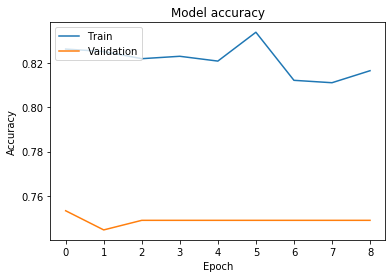

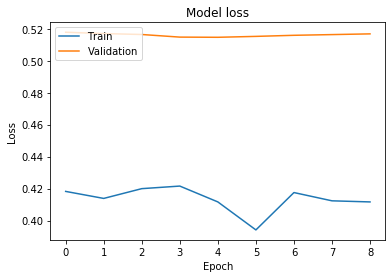

F1 score is:  0.7
Recall score is:  0.73
Precision score is:  0.7
Confusion matrix: 
 [[125  19]
 [ 66  78]]
From the confusion matrix above there are 125 true negatives and 19 false positives.
There are 66 false negatives and 78 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 439ms/step - loss: 0.8103 - acc: 0.5064 - val_loss: 0.7291 - val_acc: 0.4459

Epoch 00001: val_loss improved from inf to 0.72905, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 308ms/step - loss: 0.7791 - acc: 0.4963 - val_loss: 0.7205 - val_acc: 0.5022

Epoch 00002: val_loss improved from 0.72905 to 0.72049

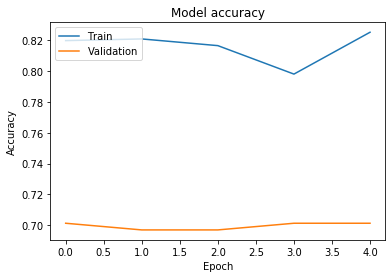

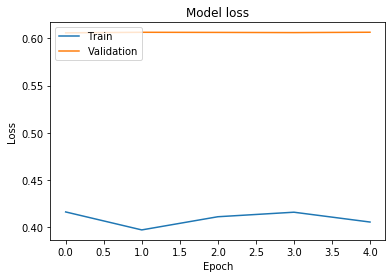

F1 score is:  0.71
Recall score is:  0.75
Precision score is:  0.72
Confusion matrix: 
 [[128  16]
 [ 64  80]]
From the confusion matrix above there are 128 true negatives and 16 false positives.
There are 64 false negatives and 80 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 25s 851ms/step - loss: 0.7870 - acc: 0.5355 - val_loss: 0.8726 - val_acc: 0.4675

Epoch 00001: val_loss improved from inf to 0.87260, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 294ms/step - loss: 0.7352 - acc: 0.5508 - val_loss: 0.8846 - val_acc: 0.4935

Epoch 00002: val_loss did not improve from 0.87260
E

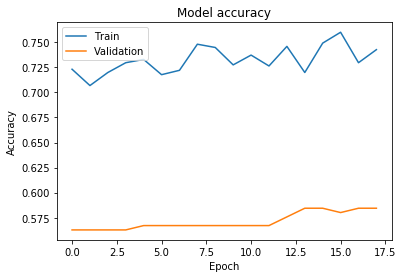

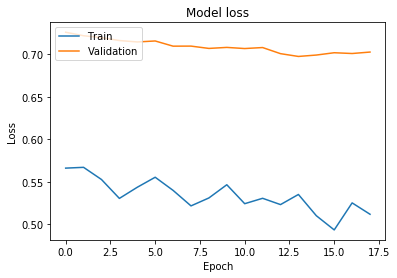

F1 score is:  0.53
Recall score is:  0.76
Precision score is:  0.6
Confusion matrix: 
 [[143   1]
 [114  30]]
From the confusion matrix above there are 143 true negatives and 1 false positives.
There are 114 false negatives and 30 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 28s 952ms/step - loss: 0.7053 - acc: 0.4983 - val_loss: 0.7003 - val_acc: 0.5325

Epoch 00001: val_loss improved from inf to 0.70032, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 542ms/step - loss: 0.7129 - acc: 0.5016 - val_loss: 0.6978 - val_acc: 0.5281

Epoch 00002: val_loss improved f


Epoch 00029: val_loss improved from 0.65131 to 0.65000, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6218 - acc: 0.6889 - val_loss: 0.6488 - val_acc: 0.6883

Epoch 00030: val_loss improved from 0.65000 to 0.64876, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6295 - acc: 0.6632 - val_loss: 0.6475 - val_acc: 0.6883

Epoch 00031: val_loss improved from 0.64876 to 0.64748, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6251 - acc: 0.6632 - val_loss: 0.6462 - val_acc: 0.6883

Epoch 00032: val_loss improved from 0.64748 to 0.64621, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5293 - acc: 0.7797 - val_loss: 0.6019 - val_acc: 0.6883

Epoch 00040: val_loss improved from 0.60233 to 0.60190, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5319 - acc: 0.7773 - val_loss: 0.6015 - val_acc: 0.6840

Epoch 00041: val_loss improved from 0.60190 to 0.60152, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5207 - acc: 0.8022 - val_loss: 0.6012 - val_acc: 0.6883

Epoch 00042: val_loss improved from 0.60152 to 0.60123, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5352 - acc: 0.7639 - val_loss: 0.6010 - val_acc: 0.6883

Epoch 00043: val_loss improved from 0.60123 to 0.60101, sa

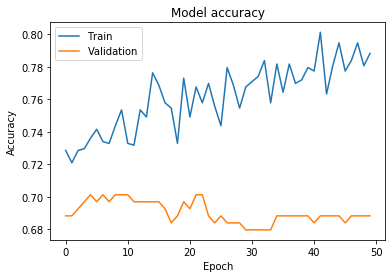

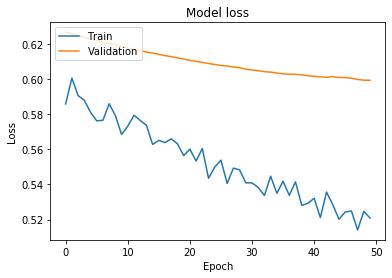

F1 score is:  0.71
Recall score is:  0.76
Precision score is:  0.72
Confusion matrix: 
 [[130  14]
 [ 66  78]]
From the confusion matrix above there are 130 true negatives and 14 false positives.
There are 66 false negatives and 78 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 934ms/step - loss: 0.6964 - acc: 0.5147 - val_loss: 0.7319 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.73185, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 541ms/step - loss: 0.6933 - acc: 0.5231 - val_loss: 0.7286 - val_acc: 0.5022

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.66153 to 0.65955, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6205 - acc: 0.6826 - val_loss: 0.6576 - val_acc: 0.6061

Epoch 00030: val_loss improved from 0.65955 to 0.65760, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6140 - acc: 0.6969 - val_loss: 0.6558 - val_acc: 0.6104

Epoch 00031: val_loss improved from 0.65760 to 0.65577, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6171 - acc: 0.6892 - val_loss: 0.6540 - val_acc: 0.6104

Epoch 00032: val_loss improved from 0.65577 to 0.65403, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5241 - acc: 0.7948 - val_loss: 0.5890 - val_acc: 0.7229

Epoch 00040: val_loss improved from 0.58935 to 0.58896, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5254 - acc: 0.7881 - val_loss: 0.5889 - val_acc: 0.7229

Epoch 00041: val_loss improved from 0.58896 to 0.58886, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 551ms/step - loss: 0.5183 - acc: 0.7811 - val_loss: 0.5885 - val_acc: 0.7186

Epoch 00042: val_loss improved from 0.58886 to 0.58854, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5235 - acc: 0.7845 - val_loss: 0.5882 - val_acc: 0.7186

Epoch 00043: val_loss improved from 0.58854 to 0.58820, sa

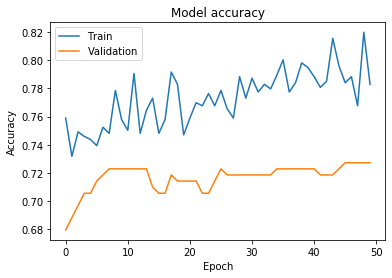

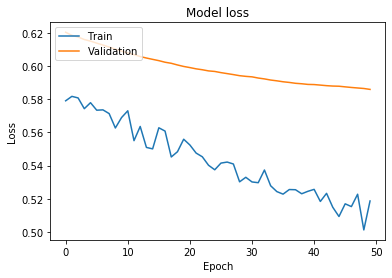

F1 score is:  0.72
Recall score is:  0.73
Precision score is:  0.72
Confusion matrix: 
 [[116  28]
 [ 53  91]]
From the confusion matrix above there are 116 true negatives and 28 false positives.
There are 53 false negatives and 91 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 26s 894ms/step - loss: 0.7216 - acc: 0.4931 - val_loss: 0.7208 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.72079, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.7240 - acc: 0.4742 - val_loss: 0.7183 - val_acc: 0.5022

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.66251 to 0.66066, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6522 - acc: 0.6336 - val_loss: 0.6588 - val_acc: 0.6061

Epoch 00030: val_loss improved from 0.66066 to 0.65880, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6465 - acc: 0.6266 - val_loss: 0.6571 - val_acc: 0.6104

Epoch 00031: val_loss improved from 0.65880 to 0.65708, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6283 - acc: 0.6600 - val_loss: 0.6554 - val_acc: 0.6104

Epoch 00032: val_loss improved from 0.65708 to 0.65541, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5461 - acc: 0.7625 - val_loss: 0.5894 - val_acc: 0.6970

Epoch 00040: val_loss improved from 0.59002 to 0.58942, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5332 - acc: 0.7736 - val_loss: 0.5890 - val_acc: 0.6970

Epoch 00041: val_loss improved from 0.58942 to 0.58896, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5322 - acc: 0.7754 - val_loss: 0.5885 - val_acc: 0.6970

Epoch 00042: val_loss improved from 0.58896 to 0.58849, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5288 - acc: 0.7682 - val_loss: 0.5880 - val_acc: 0.6970

Epoch 00043: val_loss improved from 0.58849 to 0.58797, sa

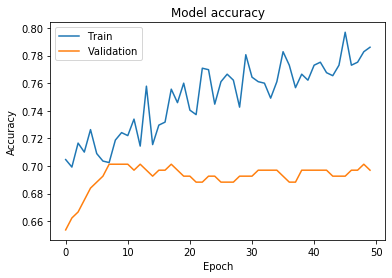

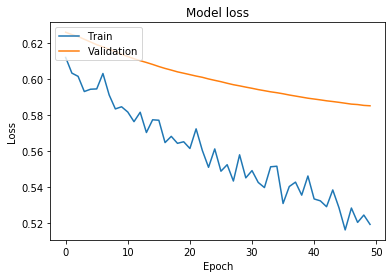

F1 score is:  0.73
Recall score is:  0.73
Precision score is:  0.73
Confusion matrix: 
 [[109  35]
 [ 44 100]]
From the confusion matrix above there are 109 true negatives and 35 false positives.
There are 44 false negatives and 100 true positives. 

Validation score of Ensemble of 1 & 2:  72.73 %
Test score of Ensemble of 1 & 2:  72.92 %
F1 score is:  0.72
Recall score is:  0.75
Precision score is:  0.73
Confusion matrix: 
 [[127  17]
 [ 61  83]]
From the confusion matrix above there are 127 true negatives and 17 false positives.
There are 61 false negatives and 83 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   
5       5   
6       6   
7       7   
8       8   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                              

ResNet50 FT Seed 7 Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 19s 669ms/step - loss: 0.7202 - acc: 0.5619 - val_loss: 0.8553 - val_acc: 0.4416

Epoch 00001: val_loss improved from inf to 0.85527, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 9s 303ms/step - loss: 0.6824 - acc: 0.5894 - val_loss: 0.8415 - val_acc: 0.4632

Epoch 00002: val_loss improved from 0.85527 to 0.84152, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 3/50
29/29 [==============================] - 8s 287ms/step - loss: 0.6609 - acc: 0.6121 - val_loss: 0.8128 - val_acc: 0.4762

Epoch 00003: val_loss improved from 0.8415

Epoch 14/50
29/29 [==============================] - 9s 293ms/step - loss: 0.3531 - acc: 0.8628 - val_loss: 0.4563 - val_acc: 0.7792

Epoch 00014: val_loss improved from 0.45835 to 0.45633, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 15/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3543 - acc: 0.8479 - val_loss: 0.4559 - val_acc: 0.7792

Epoch 00015: val_loss improved from 0.45633 to 0.45588, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.2_bestmodel.hdf5
Epoch 16/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3516 - acc: 0.8425 - val_loss: 0.4574 - val_acc: 0.7879

Epoch 00016: val_loss did not improve from 0.45588
Epoch 17/50
29/29 [==============================] - 9s 294ms/step - loss: 0.3470 - acc: 0.8461 - val_loss: 0.4563 - val_acc: 0.7879

Epoch 00017: val_loss did not improve from 0.45588
Epoch 18/50
29/29 [==============================] - 9s 295ms/step - loss: 0.3536 - acc: 0.8515 - val_loss: 

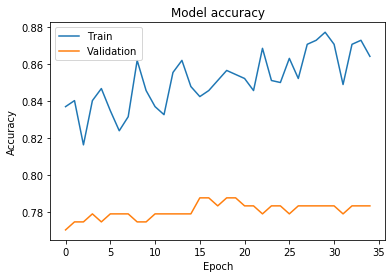

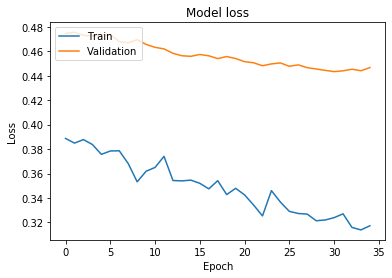

F1 score is:  0.76
Recall score is:  0.77
Precision score is:  0.76
Confusion matrix: 
 [[100  44]
 [ 24 120]]
From the confusion matrix above there are 100 true negatives and 44 false positives.
There are 24 false negatives and 120 true positives. 

ResNet50 FT Seed 7 Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 13s 444ms/step - loss: 0.8207 - acc: 0.5112 - val_loss: 0.8551 - val_acc: 0.5065

Epoch 00001: val_loss improved from inf to 0.85506, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 8s 287ms/step - loss: 0.7661 - acc: 0.5133 - val_loss: 0.8003 - val_acc: 0.5108

Epoch 00002: val_loss improved from 0.85506 to 0.80

29/29 [==============================] - 8s 286ms/step - loss: 0.4372 - acc: 0.7884 - val_loss: 0.4679 - val_acc: 0.8052

Epoch 00031: val_loss improved from 0.47484 to 0.46795, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4463 - acc: 0.7994 - val_loss: 0.4639 - val_acc: 0.8095

Epoch 00032: val_loss improved from 0.46795 to 0.46392, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 8s 287ms/step - loss: 0.4495 - acc: 0.7991 - val_loss: 0.4568 - val_acc: 0.8095

Epoch 00033: val_loss improved from 0.46392 to 0.45678, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 34/50
29/29 [==============================] - 8s 286ms/step - loss: 0.4343 - acc: 0.8062 - val_loss: 0.4571 - val_acc: 0.8095

Epoch 00034: val_loss did not improve from 0.45678
Epoch 35/50
29/29 [=========================

/home/learner/anaconda3/envs/tfgpu/lib/python3.7/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.355565). Check your callbacks.
  % delta_t_median)


29/29 [==============================] - 31s 1s/step - loss: 0.4081 - acc: 0.8282 - val_loss: 0.4269 - val_acc: 0.8139

Epoch 00001: val_loss did not improve from 0.42469
Epoch 2/50
29/29 [==============================] - 9s 307ms/step - loss: 0.4003 - acc: 0.8275 - val_loss: 0.4258 - val_acc: 0.8182

Epoch 00002: val_loss did not improve from 0.42469
Epoch 3/50
29/29 [==============================] - 11s 372ms/step - loss: 0.4037 - acc: 0.8356 - val_loss: 0.4238 - val_acc: 0.8182

Epoch 00003: val_loss improved from 0.42469 to 0.42379, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 4/50
29/29 [==============================] - 9s 295ms/step - loss: 0.3953 - acc: 0.8288 - val_loss: 0.4220 - val_acc: 0.8182

Epoch 00004: val_loss improved from 0.42379 to 0.42202, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.3_bestmodel.hdf5
Epoch 5/50
29/29 [==============================] - 8s 293ms/step - loss: 0.3966 - acc: 0.8216 - val_loss: 0.4213 - val_acc:

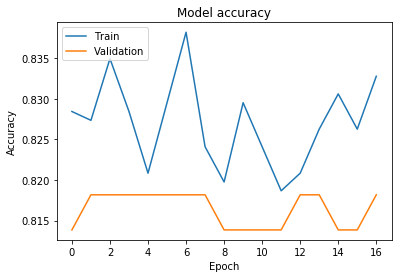

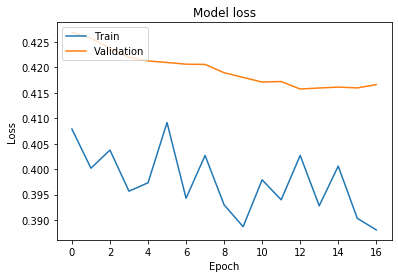

F1 score is:  0.74
Recall score is:  0.75
Precision score is:  0.74
Confusion matrix: 
 [[ 96  48]
 [ 26 118]]
From the confusion matrix above there are 96 true negatives and 48 false positives.
There are 26 false negatives and 118 true positives. 

ResNet50 FT Seed 7 Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 ResNet model 

ResNet50 1 input shape: (?, 224, 224, 3)
ResNet50 1 output shape: (?, 7, 7, 2048)
Epoch 1/50
29/29 [==============================] - 16s 553ms/step - loss: 0.7009 - acc: 0.5690 - val_loss: 0.9514 - val_acc: 0.5022

Epoch 00001: val_loss improved from inf to 0.95144, saving model to ./model/ResNet50 FT Seed 7 Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 10s 330ms/step - loss: 0.6875 - acc: 0.5902 - val_loss: 0.8715 - val_acc: 0.5065

Epoch 00002: val_loss improved from 0.95144 to 0.87

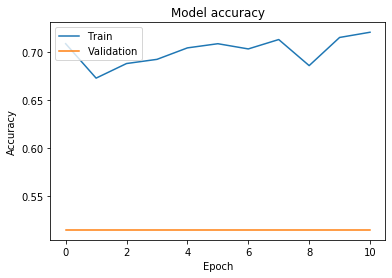

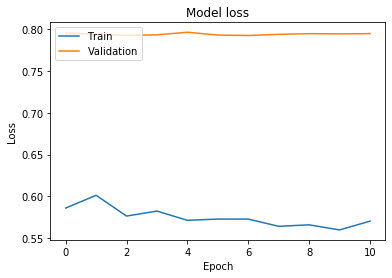

F1 score is:  0.37
Recall score is:  0.75
Precision score is:  0.52
Confusion matrix: 
 [[144   0]
 [139   5]]
From the confusion matrix above there are 144 true negatives and 0 false positives.
There are 139 false negatives and 5 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.2
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 34s 1s/step - loss: 0.7191 - acc: 0.4985 - val_loss: 0.7193 - val_acc: 0.4978

Epoch 00001: val_loss improved from inf to 0.71934, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 17s 590ms/step - loss: 0.7027 - acc: 0.5069 - val_loss: 0.7168 - val_acc: 0.4978

Epoch 00002: val_loss improved from


Epoch 00029: val_loss improved from 0.66571 to 0.66425, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6448 - acc: 0.6215 - val_loss: 0.6627 - val_acc: 0.5714

Epoch 00030: val_loss improved from 0.66425 to 0.66274, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6359 - acc: 0.6599 - val_loss: 0.6613 - val_acc: 0.5758

Epoch 00031: val_loss improved from 0.66274 to 0.66130, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 545ms/step - loss: 0.6365 - acc: 0.6560 - val_loss: 0.6599 - val_acc: 0.5844

Epoch 00032: val_loss improved from 0.66130 to 0.65990, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5419 - acc: 0.7605 - val_loss: 0.5965 - val_acc: 0.7013

Epoch 00040: val_loss improved from 0.59721 to 0.59654, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5346 - acc: 0.7792 - val_loss: 0.5958 - val_acc: 0.7013

Epoch 00041: val_loss improved from 0.59654 to 0.59585, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5287 - acc: 0.7905 - val_loss: 0.5950 - val_acc: 0.7013

Epoch 00042: val_loss improved from 0.59585 to 0.59497, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.2_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5287 - acc: 0.7957 - val_loss: 0.5943 - val_acc: 0.7013

Epoch 00043: val_loss improved from 0.59497 to 0.59429, sa

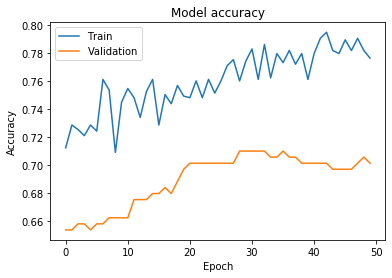

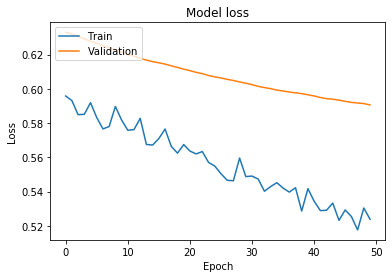

F1 score is:  0.72
Recall score is:  0.74
Precision score is:  0.73
Confusion matrix: 
 [[123  21]
 [ 58  86]]
From the confusion matrix above there are 123 true negatives and 21 false positives.
There are 58 false negatives and 86 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.3
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 931ms/step - loss: 0.7104 - acc: 0.5064 - val_loss: 0.7221 - val_acc: 0.4242

Epoch 00001: val_loss improved from inf to 0.72213, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.7035 - acc: 0.5058 - val_loss: 0.7199 - val_acc: 0.4329

Epoch 00002: val_loss improved 


Epoch 00029: val_loss improved from 0.67284 to 0.67150, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6227 - acc: 0.6843 - val_loss: 0.6702 - val_acc: 0.5758

Epoch 00030: val_loss improved from 0.67150 to 0.67018, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6332 - acc: 0.6633 - val_loss: 0.6691 - val_acc: 0.5714

Epoch 00031: val_loss improved from 0.67018 to 0.66906, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 547ms/step - loss: 0.6253 - acc: 0.6668 - val_loss: 0.6680 - val_acc: 0.5714

Epoch 00032: val_loss improved from 0.66906 to 0.66797, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

Epoch 40/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5349 - acc: 0.7671 - val_loss: 0.6173 - val_acc: 0.6494

Epoch 00040: val_loss improved from 0.61740 to 0.61725, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 554ms/step - loss: 0.5277 - acc: 0.7749 - val_loss: 0.6168 - val_acc: 0.6580

Epoch 00041: val_loss improved from 0.61725 to 0.61681, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5325 - acc: 0.7808 - val_loss: 0.6160 - val_acc: 0.6580

Epoch 00042: val_loss improved from 0.61681 to 0.61596, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.3_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 553ms/step - loss: 0.5340 - acc: 0.7782 - val_loss: 0.6160 - val_acc: 0.6537

Epoch 00043: val_loss did not improve from 0.61596
Epoch 4

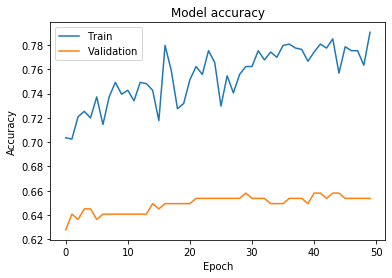

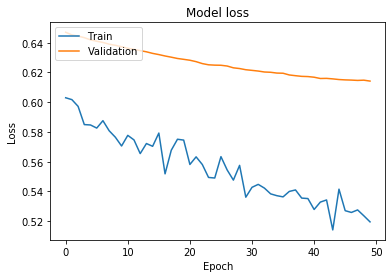

F1 score is:  0.63
Recall score is:  0.7
Precision score is:  0.65
Confusion matrix: 
 [[130  14]
 [ 86  58]]
From the confusion matrix above there are 130 true negatives and 14 false positives.
There are 86 false negatives and 58 true positives. 

EfficientNet B4 Seed 7 FT Dropout: 0.4
Band: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)
RGB: Train:  (921, 224, 224, 3) Validation: (231, 224, 224, 3) Test: (288, 224, 224, 3)

 EfficientNet model 

EffNetB4 1 input shape: (?, 224, 224, 3)
EffNetB4 1 output shape: (?, 7, 7, 1792)
Epoch 1/50
29/29 [==============================] - 27s 923ms/step - loss: 0.6986 - acc: 0.5184 - val_loss: 0.7137 - val_acc: 0.4935

Epoch 00001: val_loss improved from inf to 0.71372, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 2/50
29/29 [==============================] - 16s 544ms/step - loss: 0.6993 - acc: 0.5180 - val_loss: 0.7116 - val_acc: 0.4892

Epoch 00002: val_loss improved f


Epoch 00029: val_loss improved from 0.66511 to 0.66373, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 30/50
29/29 [==============================] - 16s 548ms/step - loss: 0.6370 - acc: 0.6466 - val_loss: 0.6625 - val_acc: 0.5931

Epoch 00030: val_loss improved from 0.66373 to 0.66250, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 31/50
29/29 [==============================] - 16s 546ms/step - loss: 0.6362 - acc: 0.6446 - val_loss: 0.6612 - val_acc: 0.5931

Epoch 00031: val_loss improved from 0.66250 to 0.66123, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 32/50
29/29 [==============================] - 16s 549ms/step - loss: 0.6342 - acc: 0.6604 - val_loss: 0.6600 - val_acc: 0.5931

Epoch 00032: val_loss improved from 0.66123 to 0.66000, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 33/50
29/29 [==============================] - 16s 5

29/29 [==============================] - 16s 552ms/step - loss: 0.5347 - acc: 0.7705 - val_loss: 0.6144 - val_acc: 0.6537

Epoch 00040: val_loss improved from 0.61493 to 0.61438, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 41/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5440 - acc: 0.7628 - val_loss: 0.6142 - val_acc: 0.6537

Epoch 00041: val_loss improved from 0.61438 to 0.61421, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 42/50
29/29 [==============================] - 16s 552ms/step - loss: 0.5299 - acc: 0.7830 - val_loss: 0.6139 - val_acc: 0.6537

Epoch 00042: val_loss improved from 0.61421 to 0.61386, saving model to ./model/EfficientNet B4 Seed 7 FT Dropout: 0.4_bestmodel.hdf5
Epoch 43/50
29/29 [==============================] - 16s 550ms/step - loss: 0.5292 - acc: 0.7768 - val_loss: 0.6130 - val_acc: 0.6537

Epoch 00043: val_loss improved from 0.61386 to 0.61298, saving model t

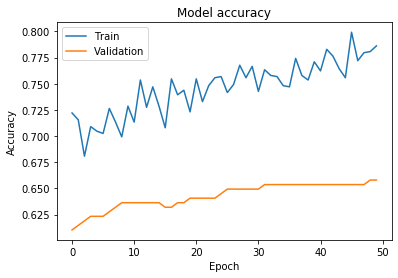

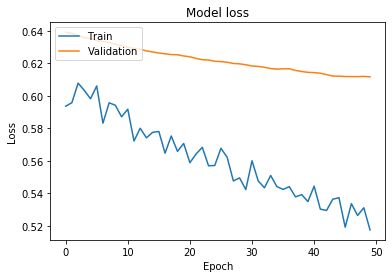

F1 score is:  0.66
Recall score is:  0.74
Precision score is:  0.68
Confusion matrix: 
 [[133  11]
 [ 81  63]]
From the confusion matrix above there are 133 true negatives and 11 false positives.
There are 81 false negatives and 63 true positives. 

Validation score of Ensemble of 1 & 2:  81.39 %
Test score of Ensemble of 1 & 2:  76.39 %
F1 score is:  0.76
Recall score is:  0.77
Precision score is:  0.76
Confusion matrix: 
 [[ 99  45]
 [ 23 121]]
From the confusion matrix above there are 99 true negatives and 45 false positives.
There are 23 false negatives and 121 true positives. 

results_data 

   Counter  \
0       0   
1       1   
2       2   
3       3   
4       4   
5       5   
6       6   
7       7   
8       8   
9       9   

   ResNet50 FT Seed 7 Dropout: 0.2 Test Acc B4 Unfreezing Last Conv Layer  \
0                                              73.26                        
1                                              71.53                        
2                  

Total running time (s): 95718 s
Total running time (min.s): 1595 min.s
Total running time (h): 26.59 hours


In [13]:
start = time.time()
print('X, y shapes: ', X.shape, y.shape)

#float32 gives faster speed and negligible loss of precision
X = X.astype('float32')

#Split the data to get a hold out test set
sss_initial = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=7)
num_splits = sss_initial.get_n_splits(X, y)

for train_val_index, test_index in sss_initial.split(X, y):
    #print('Train-Validation: ', train_val_index, 'Testing', test_index)

    X_train_val = X[train_val_index].copy()
    y_train_val = y[train_val_index].copy()

    X_test = X[test_index].copy()
    y_test = y[test_index].copy()
    
    del X, y
    #Image preprocessing ResNet50
    X_resnet50_band_train_val = resnet.preprocess_input(X_train_val[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_train_val = resnet.preprocess_input(X_train_val[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_train_val processed: max, min', np.max(X_resnet50_band_train_val), np.min(X_resnet50_band_train_val))
    print('X_resnet50_rgb_train_val processed: max, min', np.max(X_resnet50_rgb_train_val), np.min(X_resnet50_rgb_train_val))
    X_resnet50_band_test = resnet.preprocess_input(X_test[:,:,:,0:3].copy()) #Disp, phase and coherence treated as one 3 band image
    X_resnet50_rgb_test = resnet.preprocess_input(X_test[:,:,:,3:6].copy()) #RGB Sentinel image 
    print('X_resnet50_band_test processed: max, min', np.max(X_resnet50_band_test), np.min(X_resnet50_band_test))
    print('X_resnet50_rgb_test processed: max, min', np.max(X_resnet50_rgb_test), np.min(X_resnet50_rgb_test))
    
    X_effnet_band_train_val = X_train_val[:,:,:,0:3].copy()
    X_effnet_rgb_train_val = X_train_val[:,:,:,3:6].copy()
    X_effnet_band_test = X_test[:,:,:,0:3].copy()
    X_effnet_rgb_test = X_test[:,:,:,3:6].copy()
    
    #Image preprocessing EfficientNet B4
    image_size = 224
    
    for i in range(X_train_val.shape[0]):
        X_effnet_band_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_band_train_val[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_train_val[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_band_train_val[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_train_val[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_train_val[i,:,:,:]) #RGB Sentinel image 
    
    for i in range(X_test.shape[0]):
        X_effnet_band_test[i,:,:,:] = center_crop_and_resize(X_effnet_band_test[i,:,:,:], image_size=image_size) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = center_crop_and_resize(X_effnet_rgb_test[i,:,:,:], image_size=image_size) #RGB Sentinel image 
        X_effnet_band_test[i,:,:,:] = efn.preprocess_input(X_effnet_band_test[i,:,:,:]) #Disp, phase and coherence treated as one 3 band image
        X_effnet_rgb_test[i,:,:,:] = efn.preprocess_input(X_effnet_rgb_test[i,:,:,:]) #RGB Sentinel image 
    print('X_effnet_bands_train_val processed: max, min', np.max(X_effnet_band_train_val), np.min(X_effnet_band_train_val))
    print('X_effnet_rgb_train_val processed: max, min', np.max(X_effnet_rgb_train_val), np.min(X_effnet_rgb_train_val))
    print('X_effnet_bands_test processed: max, min', np.max(X_effnet_band_test), np.min(X_effnet_band_test))
    print('X_effnet_rgb_test processed: max, min', np.max(X_effnet_rgb_test), np.min(X_effnet_rgb_test))

    del X_train_val, X_test
    
    results = trainModel(img_res, X_resnet50_band_train_val, X_resnet50_band_test, X_resnet50_rgb_train_val, 
                         X_resnet50_rgb_test, y_train_val, y_test, X_effnet_band_train_val, X_effnet_band_test, 
                         X_effnet_rgb_train_val, X_effnet_rgb_test)
    
#Save results to CSV
results.to_csv('./model/' + 'FT_Seed_7_Results.csv', sep=',', index=False)

end = time.time()
elapsed = end - start
print('Total running time (s): %i s' % (elapsed))
print('Total running time (min.s): %i min.s' % (elapsed/60.0))
print('Total running time (h): %.2f hours' % (elapsed/3600.0))

## Note
- **The results are contained in the *FT_Seed_7_Results.csv'* file in the *model* folder.**